In [86]:
# Importing necessary libraries for all parts of the lab 
import numpy as np
# Provides support for large, multi-dimensional arrays and matrices.
# Useful for mathematical operations such as those needed for constructing master darks, median calculations, and image subtraction.
from scipy import stats
# Help with tasks like calculating the median or other statistical properties of the data.
from astropy.io import fits
# This is used to read and write FITS (Flexible Image Transport System) files, which is the standard format for astronomical data.
# Essential for loading the images, spectra, flat-fields, and dark frames into Python for further analysis.
from astropy.modeling import models, fitting
# Provides a framework for defining models and fitting them to data.
# Useful for tasks like wavelength calibration, where fitting a model to arc lamp spectra is needed.
import matplotlib.pyplot as plt
# A plotting library for creating visualizations such as spectra, fitted curves, and other data representations.
from numpy.polynomial import Polynomial
# Helps with creating and manipulating polynomial functions.
# Useful for tasks like fitting a polynomial to wavelength solutions or correcting for any distortions in the data.
from scipy.signal import find_peaks
# Used to identify peaks in the data, which is particularly important for finding emission or absorption lines in arc lamp spectra.
from scipy.interpolate import UnivariateSpline
from scipy.constants import h, c, k
from scipy.interpolate import interp1d

from astropy import units as u
#bb = models.BlackBody(temperature=5000*u.K)
#bb(6000 * u.AA)  
# <Quantity 1.53254685e-05 erg / (Hz s sr cm2)>

import os
from astropy.modeling.models import BlackBody

from astropy.visualization import quantity_support
from scipy.optimize import curve_fit



Section 1.1: Dark subtraction


In [87]:
# 1.1
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    # Initializes an empty list to store tuples containing the header and data of each FITS file.
    for i in range(start_idx, end_idx + 1):
        # Iterates through the specified range of indices
        file_path = file_template.format(i)
        # Uses the template to create the file path for each FITS file by inserting the current index i into the placeholder.
        with fits.open(file_path) as hdul:
            # Opens the FITS file using astropy.io.fits. The with statement ensures that the file is properly closed after reading.
            # hdul (HDU list) is an object containing all the data and metadata from the FITS file.
            header = hdul[0].header
            # Extracts （提取） the header from the primary HDU (Header Data Unit).
            data = hdul[0].data
            # Extracts the image data from the primary HDU
            frames_info.append((header, data))
            # Adds a tuple containing the header and data of the current FITS file to the frames_info list.
    return frames_info # Returns a list of tuples, where each tuple represents a FITS file’s header and data.

# Allows to load multiple images quickly and efficiently, making it easier to compute the median of a series of images.

In [88]:
def read_calibration_fits(bias_file_template, bias_start_index, bias_end_index,
                          dark_file_template, dark_start_index, dark_end_index,
                          flat_file_template, arc_lamp_file_template, start_index, end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames = read_fits_range(bias_file_template, bias_start_index, bias_end_index)
    dark_frames = read_fits_range(dark_file_template, dark_start_index, dark_end_index)
    flat_fields = read_fits_range(flat_file_template, start_index, end_index)
    arc_lamp_spectrum = read_fits_range(arc_lamp_file_template, start_index, end_index)

    return bias_frames, dark_frames, flat_fields, arc_lamp_spectrum

# Templates for the file names
bias_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\bias_frames_all_stars.{:08d}.BIAS.FIT"
dark_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\dark_frames_all_stars.{:08d}.DARK.FIT"
flat_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\flat_fields_all_stars_USETHIS.{:08d}.FIT"
arc_lamp_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\arc_lamp_merc_calibration.{:08d}.FIT"

# Define the starting and ending indices
bias_start_index = 2
bias_end_index = 11
dark_start_index = 0
dark_end_index = 1
start_index = 0  # For flat fields and mercury arc lamp spectrum
end_index = 9    # For flat fields and mercury arc lamp spectrum

# Calling the function
bias_frames, dark_frames, flat_fields, arc_lamp_spectrum = read_calibration_fits(
    bias_file_template, bias_start_index, bias_end_index,
    dark_file_template, dark_start_index, dark_end_index,
    flat_file_template, arc_lamp_file_template, start_index, end_index
)


# This function is crucial for the initial data reduction steps:

# Step 1: Reading in dark frames and constructing master darks.
# Step 2: Preparing calibration frames (dark, bias, flat, and arc spectra) for subtraction and correction of science data.
# Step 3: Reading flat fields to create a master flat.
# Step 4: Preparing the arc lamp spectra for wavelength calibration.


In [89]:
def read_spectra_fits(star_file_templates, start_index, end_index):
    """
    Read FITS files for spectral data of seven stars.

    :param star_file_templates: List of template paths for each star's spectral FITS files, with placeholders for the frame number.
    :type star_file_templates: list of str
    :param start_index: The starting index for the frames for all stars.
    :type start_index: int
    :param end_index: The ending index for the frames for all stars.
    :type end_index: int
    :return: Seven variables, each containing lists of headers and data for a star's spectra.
    :rtype: tuple of lists of tuples
    """
    # Read the spectral frames for each star
    star1_frames = read_fits_range(star_file_templates[0], start_index, end_index)
    star2_frames = read_fits_range(star_file_templates[1], start_index, end_index)
    star3_frames = read_fits_range(star_file_templates[2], start_index, end_index)
    star4_frames = read_fits_range(star_file_templates[3], start_index, end_index)
    star5_frames = read_fits_range(star_file_templates[4], start_index, end_index)
    star6_frames = read_fits_range(star_file_templates[5], start_index, end_index)
    star7_frames = read_fits_range(star_file_templates[6], start_index, end_index)

    return star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames

# Templates for each star's spectral FITS file names
star_file_templates = [
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Vega_Class_A_USETHIS.{:08d}.FIT",                # First star/spectrophotometric star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Bet_Peg_M_star_Fourth_Star.{:08d}.FIT",            # Second star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Alf_Per_F_star_First_Star_USETHIS.{:08d}.FIT",     # Third star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Bet_Per_B_Class_Third_Star_USETHIS.{:08d}.FIT",    # Fourth star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Alf_Cas_K_star_Second_Star_USETHIS.{:08d}.FIT",    # Fifth star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Alf_Aur_G_star_Fifth_Star_USETHIS.{:08d}.FIT",     # Sixth star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\ksi_Per_O_star_Sixth_Star_USETHIS.{:08d}.FIT"      # Seventh star
]

# Define the starting and ending indices for star spectra files
start_index = 0
end_index = 1

# Calling the function to read the spectral frames
star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames = read_spectra_fits(star_file_templates, start_index, end_index)

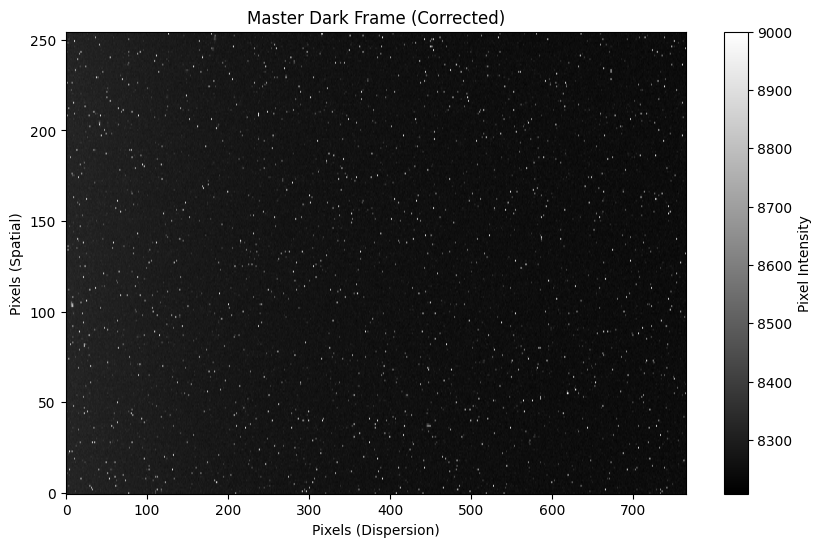

In [90]:
def create_master_dark(dark_frames):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """

    # dark_frames: A list of tuples containing headers and data for each dark frame. 
    # Each tuple has a FITS header and a 2D numpy array (data).
    # Create the master dark frame by median-combining the dark frames
    dark_data_list = [frame[1] for frame in dark_frames]  # Extract the 'data' part from each dark frame
    master_dark = np.median(np.stack(dark_data_list), axis=0)

    # Extracts the data (2D numpy arrays) from each tuple in dark_frames.
    # Stacks these arrays into a 3D array using np.stack and calculates the median across the stack along the specified axis (axis=0), 
    # which computes the median for each pixel.
    # This process effectively reduces random noise and outliers, such as cosmic ray hits, in the combined master dark frame.

    # Filter the master dark frame
    master_dark[master_dark > 9000] = 9000  # Clamp values above 9000
    # Plotting the master dark frame with a maximum value of 9000
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame (Corrected)')
    plt.grid(False)
    plt.show()

    return master_dark

# Example call to the function 
master_dark_corrected = create_master_dark(dark_frames)
# This line calls the function using dark_frames (assumed to be already loaded) and creates a corrected master dark frame.
# The resulting master_dark_corrected can be used in further data reduction, 
# such as subtracting it from science frames to remove consistent dark noise.
# This function produces a clean master dark frame by combining multiple individual dark frames, 
# reducing noise and cosmic ray artifacts. 
# The visualization step helps ensure that the master dark looks as expected before applying it to other images.

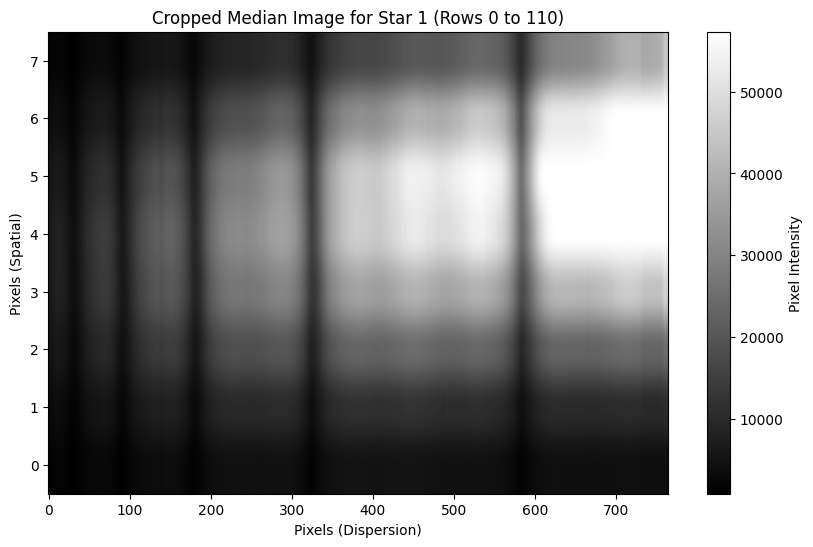

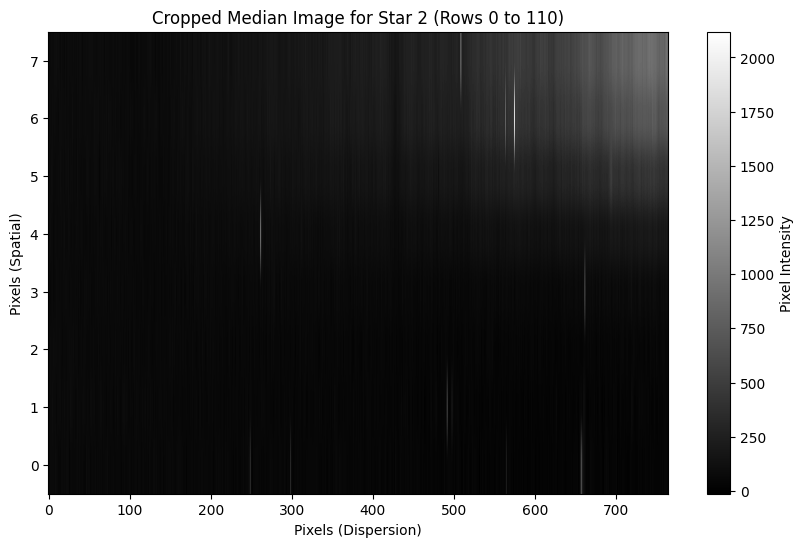

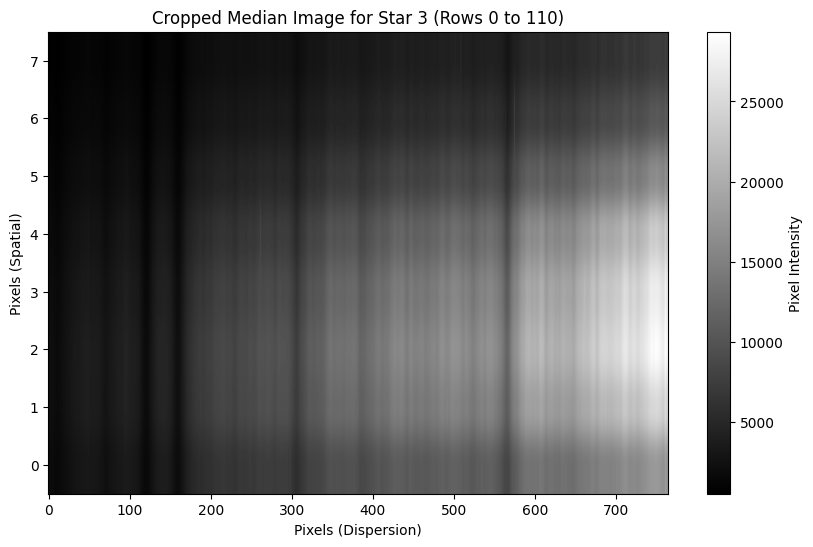

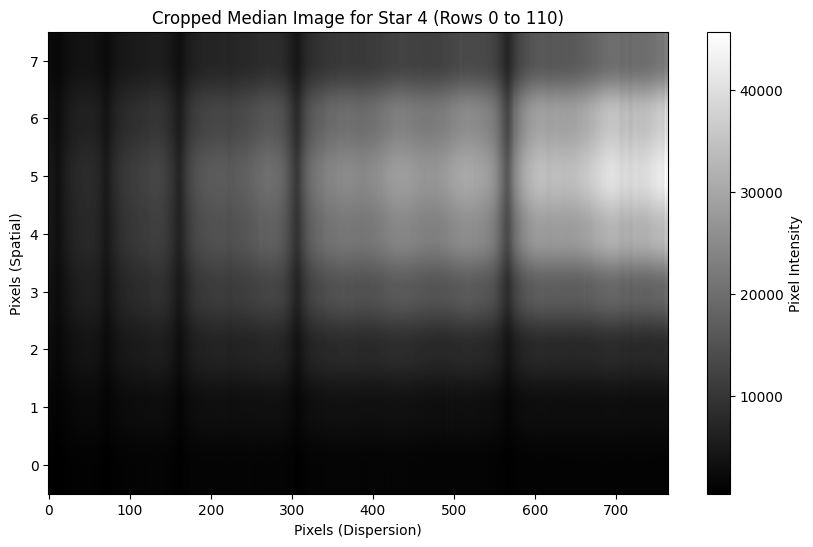

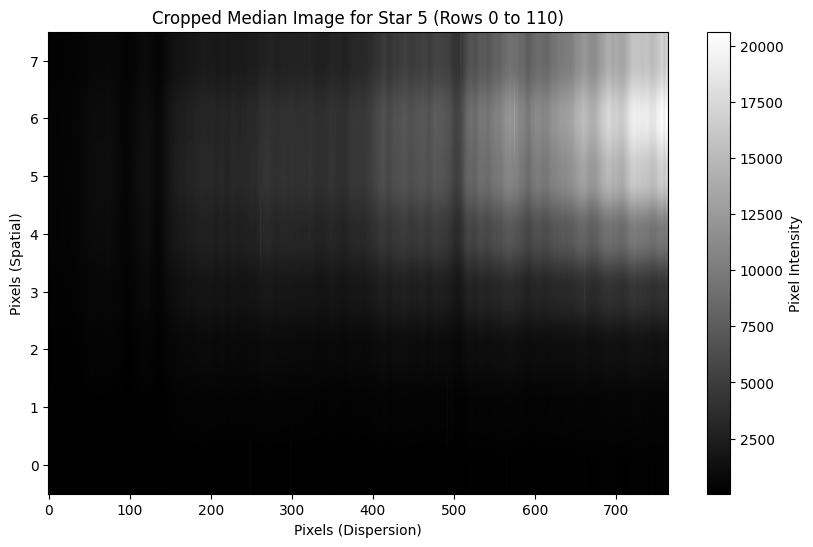

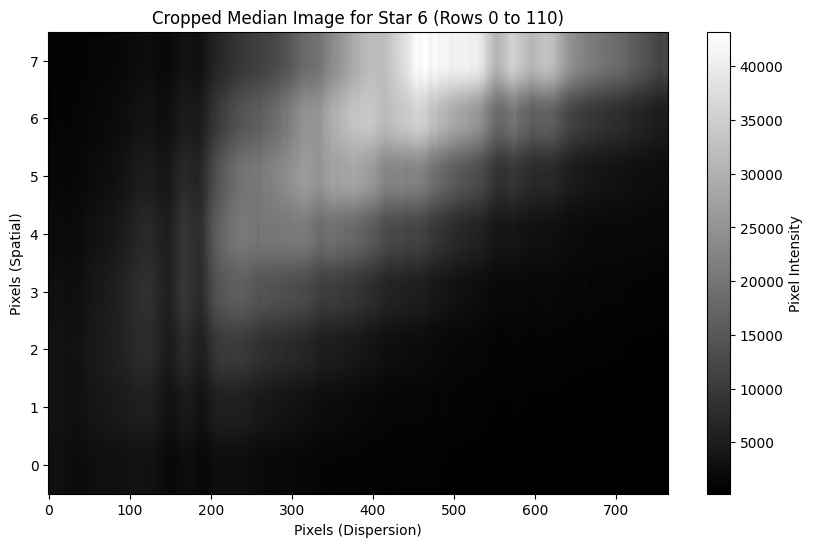

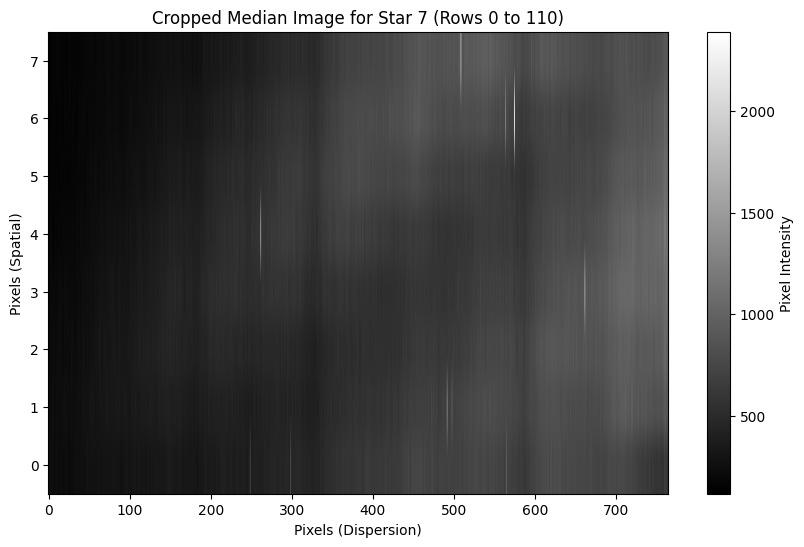

In [91]:
def create_median_images(spectra_frames, master_dark_corrected, row_start=45, row_end=53):
    """
    Subtract the master dark frame from each star's frames, crop the y-axis to the specified spectral region,
    and compute the median image for each star.

    :param spectra_frames: A tuple containing lists of headers and data for each star's spectra.
                           Each list contains tuples of (header, data), where `data` is a 2D numpy array.
    :type spectra_frames: tuple of lists of tuples
    :param master_dark_corrected: The master dark frame to be subtracted.
    :type master_dark_corrected: np.ndarray
    :param row_start: The starting index for the row range (y-axis) to crop the image.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the image.
    :type row_end: int
    :return: A list of median images for each star after dark subtraction and cropping.
    :rtype: list of np.ndarray
    """
    median_images = []
    # Creates an empty list median_images to store the median image for each star.
    # Subtract the master dark from each star's frames, crop the spectral region, and compute the median
    for frames in spectra_frames:
    # Looping Through Stars: For each star’s list of frames (frames):
    # Extracts the data from each frame (2D numpy arrays) into star_data_list.
        star_data_list = [frame[1] for frame in frames]  # Extract the 'data' part from each star frame
        corrected_images = [data - master_dark_corrected for data in star_data_list]  # Subtract the master dark
        # Dark Subtraction:
        # Subtracts the master_dark_corrected frame from each 2D array (image) in star_data_list, removing dark noise.

        cropped_images = [img[row_start:row_end, :] for img in corrected_images]  # Crop the y-axis
        # Cropping:
        # Crops the images along the y-axis from row_start to row_end to focus on the specific spectral region of interest, 
        # ignoring parts of the image outside this range.

        # Compute the median image for the cropped spectral region
        median_image = np.median(np.stack(cropped_images), axis=0)
        median_images.append(median_image)
        # Median Combination:
        # Uses np.median with np.stack to combine the cropped images, taking the median at each pixel location along the stack.
        # This reduces noise further and produces a clean spectral image for each star.
        # Store the Result:
        # Appends the median image for the current star to median_images.

    return median_images

# Example call to the function
spectra_frames = (star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames)
median_images = create_median_images(spectra_frames, master_dark_corrected)
# Call uses the spectra_frames tuple, which contains data for all seven stars, and the master_dark_corrected frame.
# It produces a list of median images, where each image corresponds to a star and represents its spectrum after dark subtraction and cropping.

# Dark Subtraction: Removes unwanted noise from each spectral frame using the master dark.
# Cropping: Focuses the analysis on a specific y-range that corresponds to the illuminated region of interest.
# Median Combination: Reduces noise and artifacts by taking the median of multiple exposures, resulting in a clearer spectral image.


# Optional: Plot the cropped median images for each star
for i, median_image in enumerate(median_images):
    plt.figure(figsize=(10, 6))
    plt.imshow(median_image, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.title(f'Cropped Median Image for Star {i+1} (Rows {0} to {110})')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.grid(False)
    plt.show()

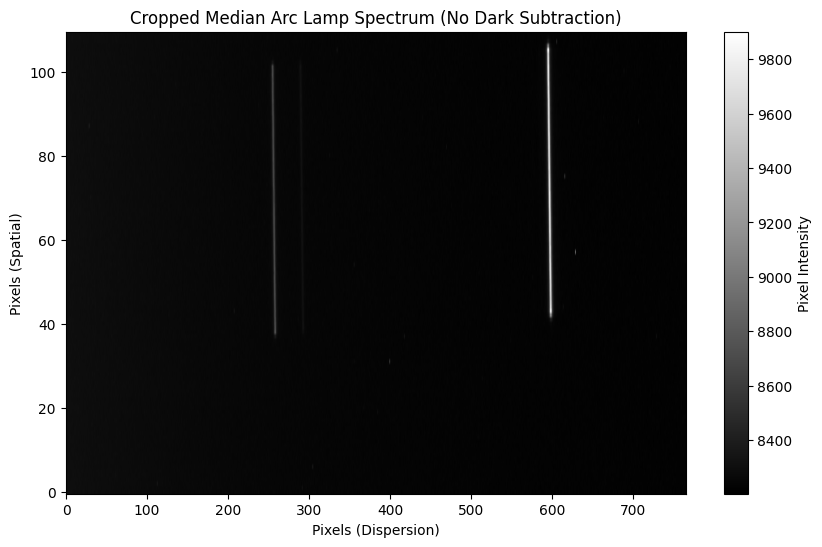

In [92]:
def create_median_arc_spectrum(arc_lamp_spectrum, row_start=0, row_end=110):
    """
    Compute the median arc lamp spectrum by cropping the y-axis to the specified spectral region 
    without subtracting the master dark frame.

    :param arc_lamp_spectrum: List of tuples containing headers and data for the arc lamp spectrum.
                              Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type arc_lamp_spectrum: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the spectrum.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the spectrum.
    :type row_end: int
    :return: Median arc lamp spectrum after cropping.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each arc lamp frame
    arc_data_list = [frame[1] for frame in arc_lamp_spectrum]
    # Crop the y-axis of each arc lamp frame
    cropped_arc_data_list = [data[row_start:row_end, :] for data in arc_data_list]
    # Compute the median of the cropped arc lamp spectra (no dark subtraction)
    median_arc_spectrum = np.median(np.stack(cropped_arc_data_list), axis=0)
    return median_arc_spectrum

# Calling the function
median_arc_spectrum = create_median_arc_spectrum(arc_lamp_spectrum)

# Optional: Plot the median arc lamp spectrum
plt.figure(figsize=(10, 6))
plt.imshow(median_arc_spectrum, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Cropped Median Arc Lamp Spectrum (No Dark Subtraction)')
plt.grid(False)
plt.show()


Section 1.2: Flat-Fielding

In [93]:
# 1.2
'''
def median_flat_field(flat_fields, median_bias_frame, row_start=40, row_end=100):
    """
    Compute the median flat field image without subtracting the master dark frame,
    crop the y-axis to the specified region, and clamp values above 9000.

    :param flat_fields: List of tuples containing headers and 2D numpy array data for flat field frames.
    :type flat_fields: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the flat fields.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the flat fields.
    :type row_end: int
    :return: The median flat field image cropped to the specified region and filtered.
    :rtype: np.ndarray
    """
    
    # Extract the 'data' part from each flat field frame and crop the y-axis
    flat_field_data_list = [frame[1][row_start:row_end, :] for frame in flat_fields]
    # Create the median flat field image from the flat fields (no dark subtraction)
    median_flat_field_image = np.median(np.stack(flat_field_data_list), axis=0) - median_bias_frame[row_start:row_end]
    # Clamp values above 9000
    # median_flat_field_image[median_flat_field_image > 9000] = 9000
    
    return median_flat_field_image

# Calling the function
median_flat_field_image = median_flat_field(flat_fields,median_bias_frame=np.median([b[1] for b in bias_frames],axis=0))

# Optional: Plotting the filtered median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(median_flat_field_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Filtered Median Flat Field Image (Median bias frame Subtraction)')
plt.grid(False)
plt.show()
'''

'\ndef median_flat_field(flat_fields, median_bias_frame, row_start=40, row_end=100):\n    """\n    Compute the median flat field image without subtracting the master dark frame,\n    crop the y-axis to the specified region, and clamp values above 9000.\n\n    :param flat_fields: List of tuples containing headers and 2D numpy array data for flat field frames.\n    :type flat_fields: list of tuples\n    :param row_start: The starting index for the row range (y-axis) to crop the flat fields.\n    :type row_start: int\n    :param row_end: The ending index for the row range (y-axis) to crop the flat fields.\n    :type row_end: int\n    :return: The median flat field image cropped to the specified region and filtered.\n    :rtype: np.ndarray\n    """\n    \n    # Extract the \'data\' part from each flat field frame and crop the y-axis\n    flat_field_data_list = [frame[1][row_start:row_end, :] for frame in flat_fields]\n    # Create the median flat field image from the flat fields (no dark s

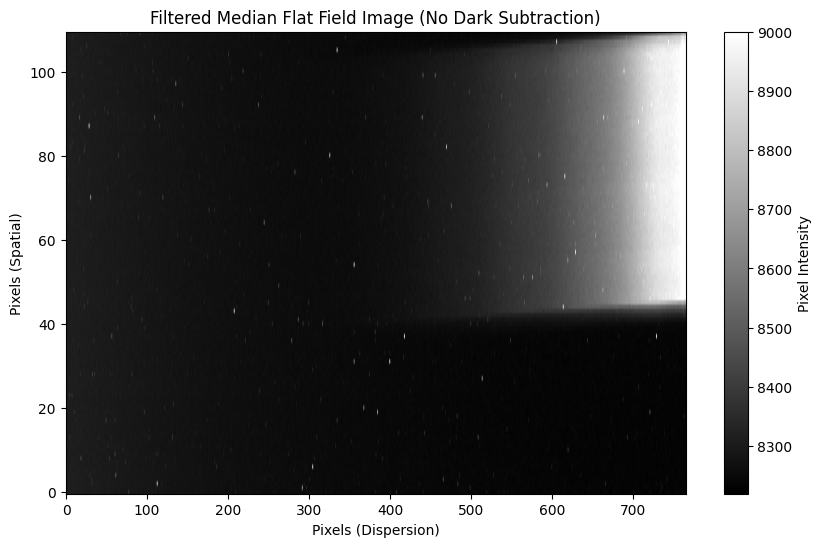

In [94]:
def median_flat_field(flat_fields, row_start=0, row_end=110):
    """
    Compute the median flat field image without subtracting the master dark frame,
    crop the y-axis to the specified region, and clamp values above 9000.

    :param flat_fields: List of tuples containing headers and 2D numpy array data for flat field frames.
    :type flat_fields: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the flat fields.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the flat fields.
    :type row_end: int
    :return: The median flat field image cropped to the specified region and filtered.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each flat field frame and crop the y-axis
    flat_field_data_list = [frame[1][row_start:row_end, :] for frame in flat_fields]
    # Create the median flat field image from the flat fields (no dark subtraction)
    median_flat_field_image = np.median(np.stack(flat_field_data_list), axis=0)
    # Clamp values above 9000
    median_flat_field_image[median_flat_field_image > 9000] = 9000
    
    return median_flat_field_image

# Calling the function
median_flat_field_image = median_flat_field(flat_fields)

# Optional: Plotting the filtered median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(median_flat_field_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Filtered Median Flat Field Image (No Dark Subtraction)')
plt.grid(False)
plt.show()

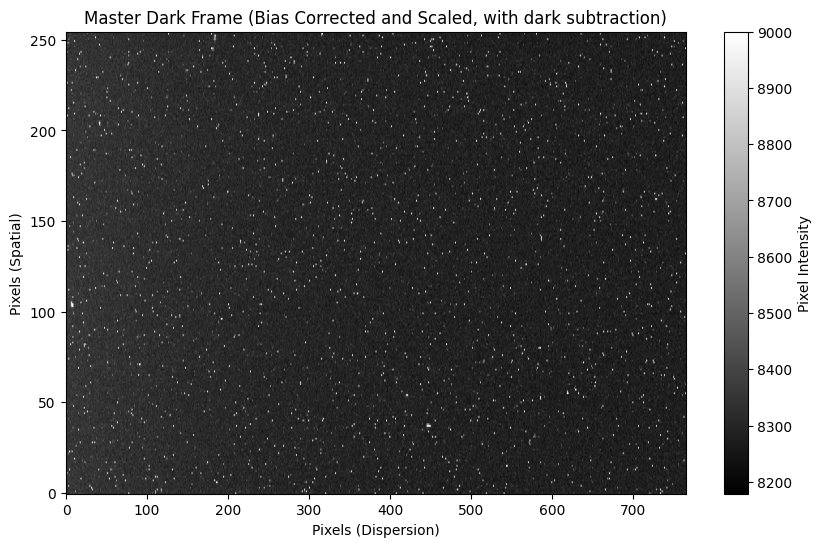

In [95]:
def create_master_dark_with_bias_correction_or_dark_subtraction(dark_frames, bias_frames, exposure_time, dark_exposure_time, row_start=50,row_end=90):
    """
    THIS IS THE CORRECT DARK SUBTRACTION !!!
    
    [Create a master dark frame by median-combining the dark frames, subtracting the master bias frame,
    scaling by the exposure time ratio, and adding back the bias frame.]

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :param bias_frames: List of tuples containing headers and data for the bias FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type bias_frames: list of tuples
    :param exposure_time: Exposure time of the science images in seconds.
    :type exposure_time: float
    :param dark_exposure_time: Exposure time of the dark frames in seconds.
    :type dark_exposure_time: float
    :return: Master dark frame after bias correction and scaling.
    :rtype: np.ndarray
    """
    # Create the master dark frame by median-combining the dark frames
    dark_data_list = [frame[1] for frame in dark_frames]  # Extract the 'data' part from each dark frame
    master_dark = np.median(np.stack(dark_data_list), axis=0)

    # Create the master bias frame by median-combining the bias frames
    bias_data_list = [frame[1] for frame in bias_frames]  # Extract the 'data' part from each bias frame
    master_bias = np.median(np.stack(bias_data_list), axis=0)

    # Subtract the master bias frame from the master dark frame
    master_dark_corrected = master_dark - master_bias

    # Scale the corrected master dark frame by (exposure_time / dark_exposure_time)
    scaling_factor = exposure_time / dark_exposure_time
    master_dark_corrected *= scaling_factor

    # Add back the master bias frame
    master_dark_corrected += master_bias

    # Filter the master dark frame
    master_dark_corrected[master_dark_corrected > 9000] = 9000  # Clamp values above 9000

    # Plotting the master dark frame with a maximum value of 9000
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_corrected, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame (Bias Corrected and Scaled, with dark subtraction)')
    plt.grid(False)
    plt.show()

    return master_dark_corrected


# Example call to the function 
master_dark_corrected = create_master_dark_with_bias_correction_or_dark_subtraction(dark_frames, bias_frames, exposure_time=300, dark_exposure_time=120)

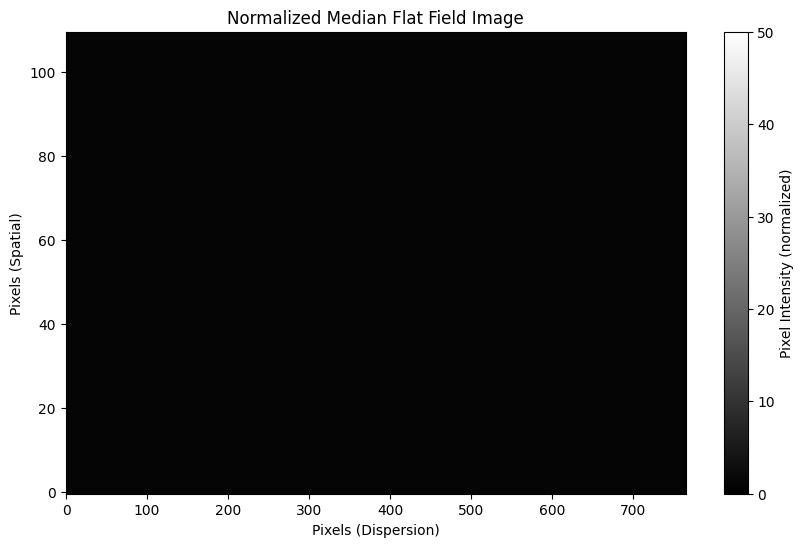

In [96]:
def normalize_flat_field(median_flat_field_image):
    """
    Normalize the median flat field image by dividing it by its mode.

    :param median_flat_field_image: The median flat field image to be normalized.
    :type median_flat_field_image: np.ndarray
    :return: The normalized median flat field image.
    :rtype: np.ndarray
    """
    # Calculate the mode for normalization
    mode_value = stats.mode(median_flat_field_image, axis=None, keepdims=True).mode[0]
    # Normalize the median flat field by dividing by its mode
    if mode_value != 0:  # Avoid division by zero
        normalized_flat_field = median_flat_field_image / mode_value
    else:
        print("Mode value is zero, skipping normalization.")
        normalized_flat_field = median_flat_field_image

    return normalized_flat_field

# Calling the function 
normalized_flat_field_image = normalize_flat_field(median_flat_field_image)#[40:100]

# Optional: Plotting the normalized median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(normalized_flat_field_image, cmap='gray', origin='lower', aspect='auto',vmin=0,vmax=50)
plt.colorbar(label='Pixel Intensity (normalized)')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Normalized Median Flat Field Image')
plt.grid(False)
plt.show()

Section 1.3: Normalize each spectrum to flat-field spectrum

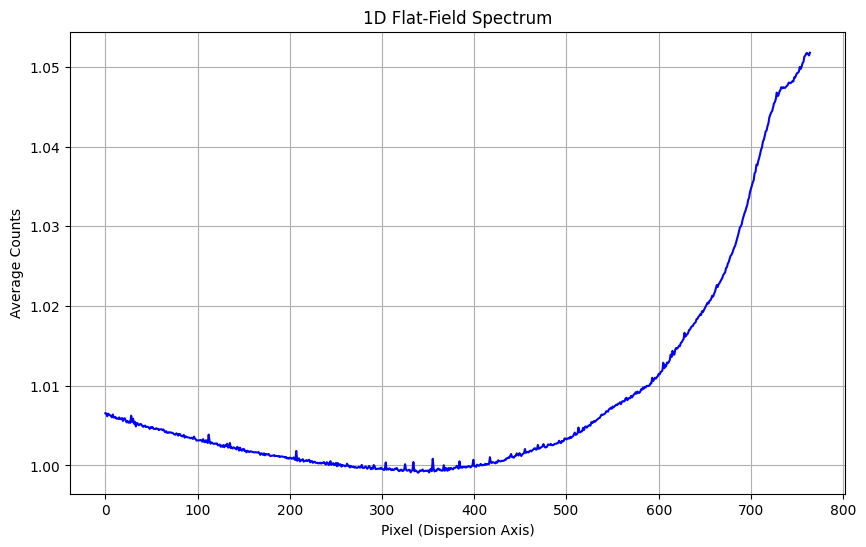

In [97]:
# 1.3

def collapse_flat_field_1d(normalized_flat_field_image):
    """
    Collapse the 2D normalized flat field image to a 1D spectrum
    by averaging the counts in each column.

    :param normalized_flat_field_image: The normalized median flat field image.
    :type normalized_flat_field_image: np.ndarray
    :return: 1D array of averaged counts.
    :rtype: np.ndarray
    """
    # Collapse the 2D image to a 1D array by taking the mean of each column
    flat_1d = np.mean(normalized_flat_field_image, axis=0)
    # Plot the 1D flat-field values against pixel positions
    plt.figure(figsize=(10, 6))
    plt.plot(flat_1d, color='blue')
    plt.title('1D Flat-Field Spectrum')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Average Counts')
    plt.grid(True)
    plt.show()

    return flat_1d

# Calling the function
flat_1d = collapse_flat_field_1d(normalized_flat_field_image)

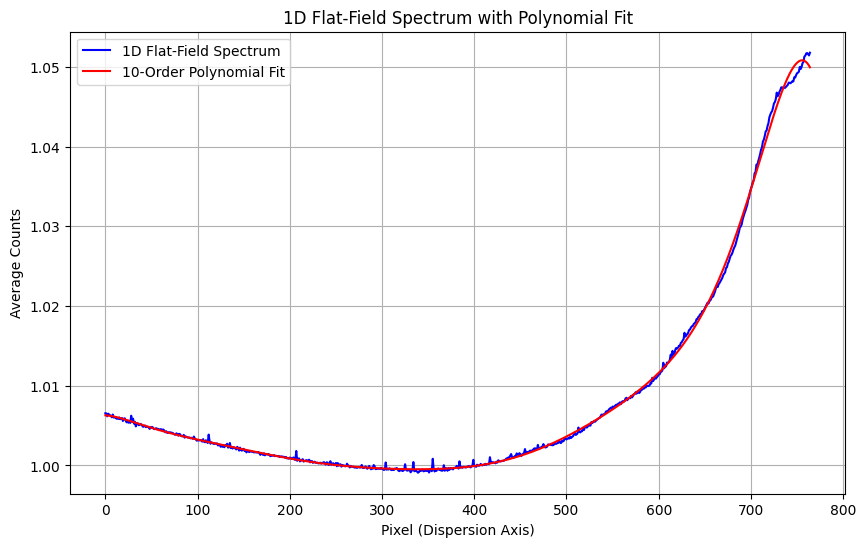

In [98]:
def fit_polynomial_to_flat_field(flat_1d, degree=10):
    """
    Fit a polynomial to the 1D flat-field spectrum and plot the results.

    :param flat_1d: The 1D array of averaged counts from the flat-field image.
    :type flat_1d: np.ndarray
    :param degree: The degree of the polynomial to fit (default is 4).
    :type degree: int
    :return: Coefficients of the fitted polynomial.
    :rtype: np.ndarray
    """
    # Fit a polynomial to the 1D flat-field data
    x_axis = np.arange(len(flat_1d))
    polynomial_fit = Polynomial.fit(x_axis, flat_1d, deg=degree)
    # Evaluate the polynomial fit
    fit_values = polynomial_fit(x_axis)
    # Plot the 1D flat-field values and the polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(flat_1d, label='1D Flat-Field Spectrum', color='blue')
    plt.plot(fit_values, label=f'{degree}-Order Polynomial Fit', color='red')
    plt.title('1D Flat-Field Spectrum with Polynomial Fit')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Average Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the polynomial coefficients
    return polynomial_fit.convert().coef

# Example call
polynomial_coefficients = fit_polynomial_to_flat_field(flat_1d)

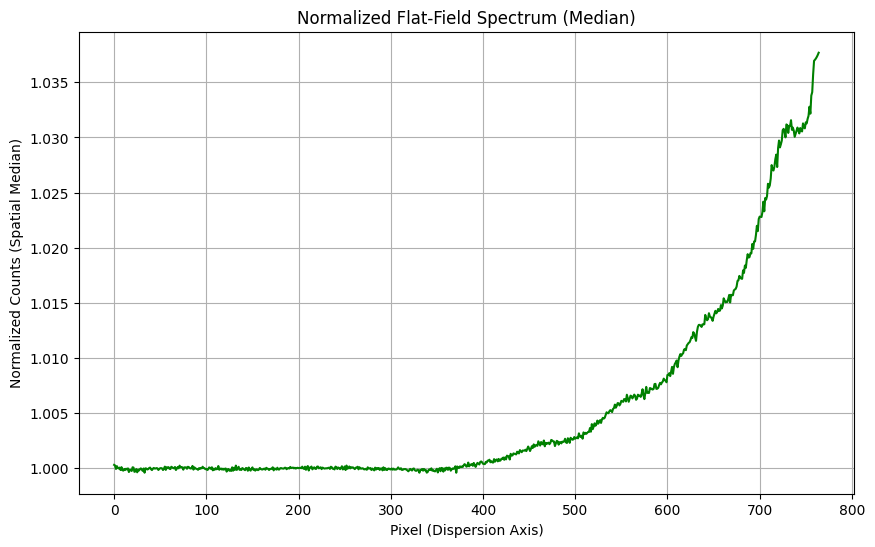

In [99]:
def normalize_flat_field_2d(normalized_flat_field_image, polynomial_coefficients):
    """
    Normalize the 2D flat-field image by dividing each row by the fitted polynomial.

    :param normalized_flat_field_image: The 2D array representing the normalized flat-field image.
    :type normalized_flat_field_image: np.ndarray
    :param polynomial_coefficients: Coefficients of the fitted polynomial.
    :type polynomial_coefficients: np.ndarray
    :return: The normalized flat-field image.
    :rtype: np.ndarray
    """
    # Generate the x-axis corresponding to the columns of the flat field
    x_axis = np.arange(normalized_flat_field_image.shape[1])
    # Evaluate the polynomial fit at each x position
    polynomial_fit_values = Polynomial(polynomial_coefficients)(x_axis)
    # Normalize the flat field by dividing each row by the polynomial fit values
    normalized_flat_field_poly = normalized_flat_field_image / polynomial_fit_values
    # Handle potential division by zero or NaN values
    normalized_flat_field_poly[np.isnan(normalized_flat_field_poly)] = 1000000  # Set NaNs to 1000000
    normalized_flat_field_poly[np.isinf(normalized_flat_field_poly)] = 1000000  # Set Infs to 1000000

    # Plot the median normalized flat field along the dispersion axis
    plt.figure(figsize=(10, 6))
    plt.plot(np.median(normalized_flat_field_poly, axis=0), color='green')
    plt.title('Normalized Flat-Field Spectrum (Median)')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Normalized Counts (Spatial Median)')
    plt.grid(True)
    plt.show()

    return normalized_flat_field_poly

# Example call
normalized_flat_field_poly = normalize_flat_field_2d(normalized_flat_field_image, polynomial_coefficients)

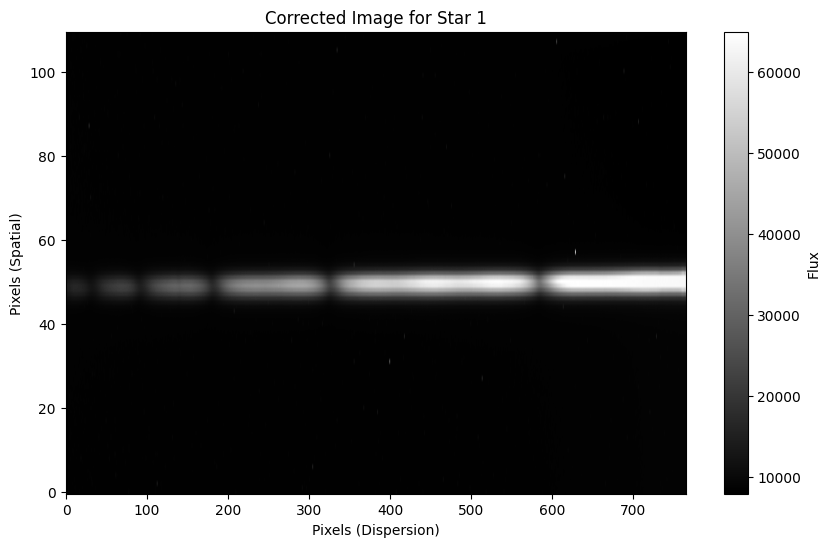

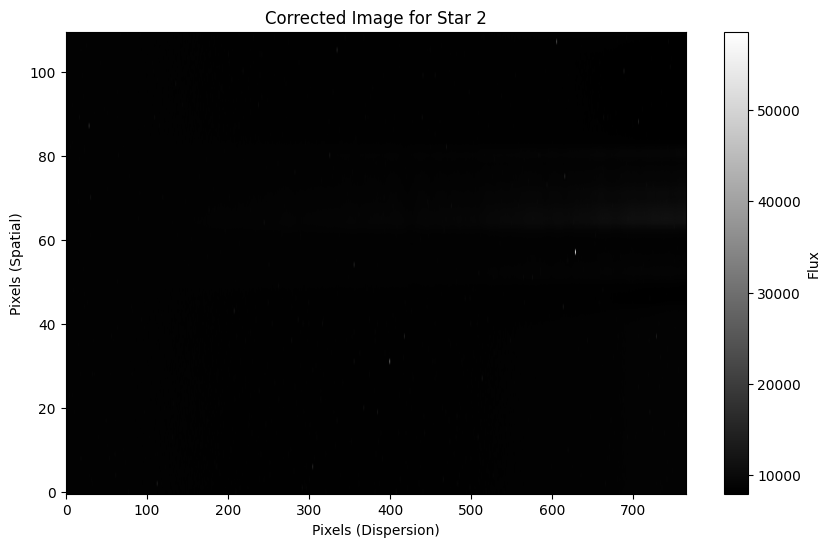

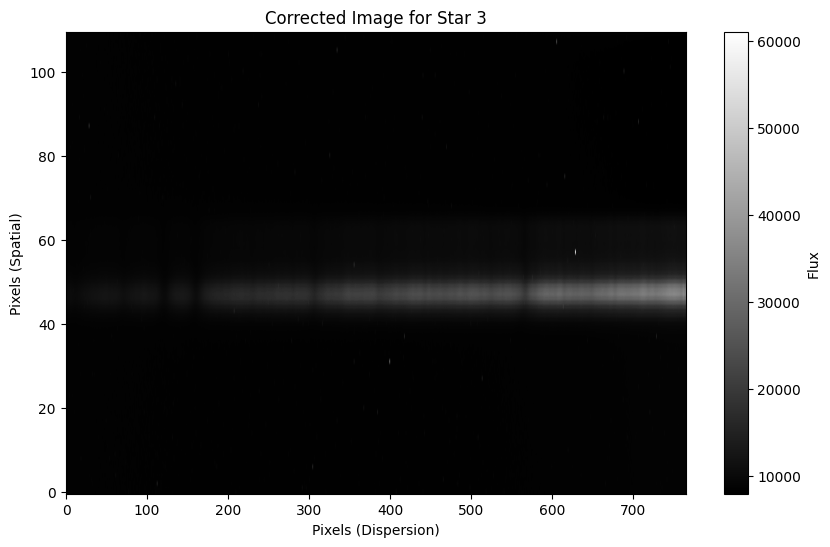

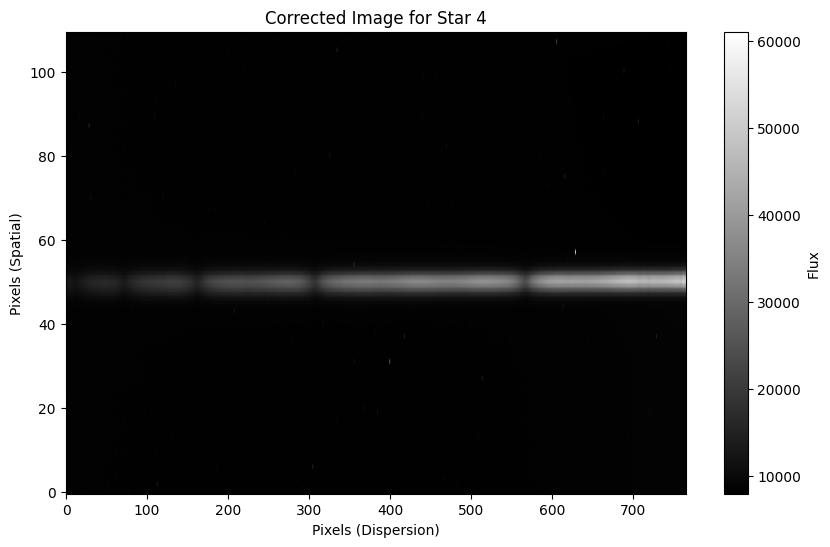

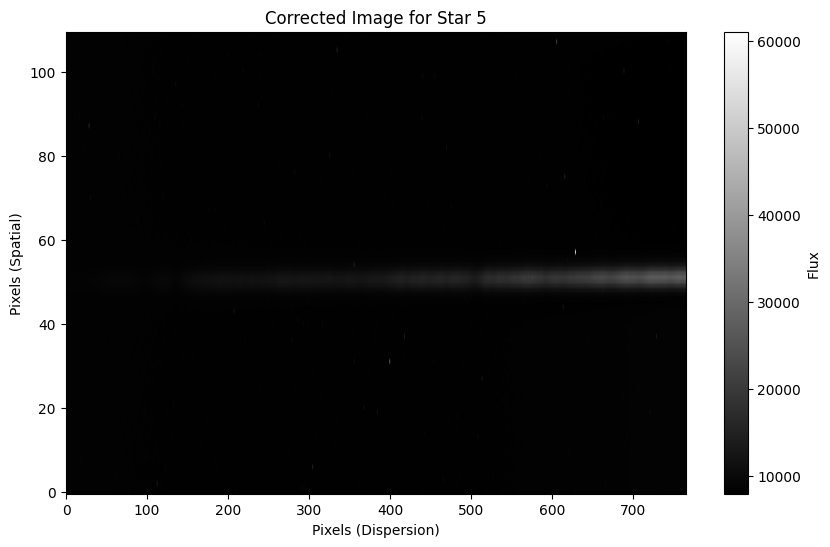

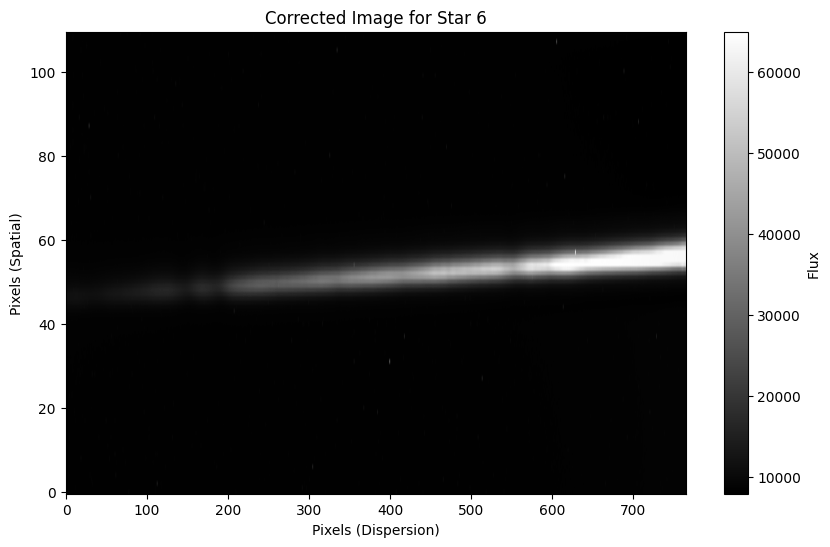

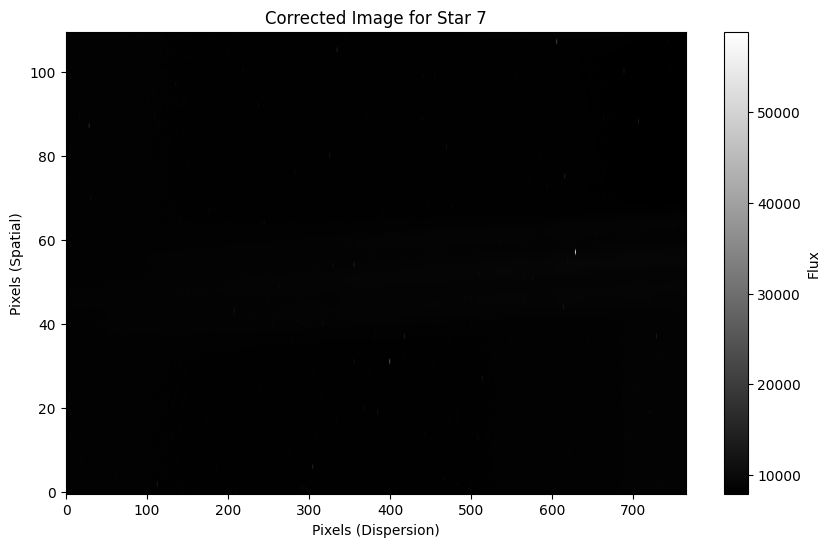

In [100]:
def correct_science_images(spectra_frames, normalized_flat_field_from_polynomial, row_start=0, row_end=110):
    """
    Correct each science image by dividing it by the normalized flat field from polynomial fitting
    and cropping the spectra frames.

    :param spectra_frames: A tuple containing lists of headers and data for each star's spectra.
                          Each list contains tuples of (header, data).
    :type spectra_frames: tuple of lists of tuples
    :param normalized_flat_field_from_polynomial: The normalized 2D flat-field image to divide by.
    :type normalized_flat_field_from_polynomial: np.ndarray
    :param row_start: Starting row index for cropping.
    :type row_start: int
    :param row_end: Ending row index for cropping.
    :type row_end: int
    :return: A list of corrected and cropped science images for each star.
    :rtype: list of np.ndarray
    """
    corrected_images = []
    # Iterate over each star's frames
    for frames in spectra_frames:
        # Extract the 'data' part from each star frame
        star_data_list = [frame[1] for frame in frames]  
        # Calculate the median image across the star data
        median_star_image = np.median(star_data_list, axis=0)
        # Divide the median star image by the normalized flat field and crop the image
        corrected_image = median_star_image[row_start:row_end, :] / normalized_flat_field_from_polynomial
        corrected_images.append(corrected_image)

    return corrected_images

# Calling the function 
corrected_spectra_images = correct_science_images(spectra_frames, normalized_flat_field_poly)

# Optional: Plotting the corrected images for each star
for star_index, corrected_image in enumerate(corrected_spectra_images):
    plt.figure(figsize=(10, 6))
    plt.imshow(corrected_image, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Flux')
    plt.title(f'Corrected Image for Star {star_index + 1}')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.grid(False)
    plt.show()

Corrected median arc spectrum saved to corrected_median_arc_spectrum.fits


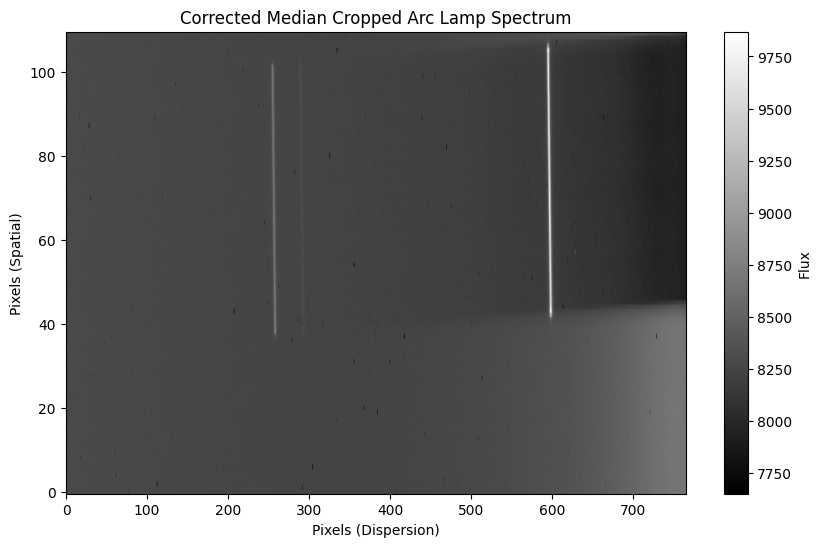

In [101]:
def correct_arc_lamp_spectrum(arc_lamp_spectrum, normalized_flat_field_from_polynomial, row_start=0, row_end=110, output_filename='corrected_median_arc_spectrum.fits'):
    """
    Correct the arc lamp spectrum by taking the median of the cropped spectra frames
    and dividing by the normalized flat field from polynomial fitting.

    :param arc_lamp_spectrum: A list containing tuples of (header, data) for the arc lamp frames.
    :type arc_lamp_spectrum: list of tuples
    :param normalized_flat_field_from_polynomial: The normalized 2D flat-field image to divide by.
    :type normalized_flat_field_from_polynomial: np.ndarray
    :param row_start: Starting row index for cropping.
    :type row_start: int
    :param row_end: Ending row index for cropping.
    :type row_end: int
    :param output_filename: Name of the output FITS file.
    :type output_filename: str
    :return: The corrected median arc lamp spectrum.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each arc lamp frame
    arc_data_list = [frame[1] for frame in arc_lamp_spectrum]
    # Crop the y-axis of each arc lamp frame
    cropped_arc_data_list = [data[row_start:row_end, :] for data in arc_data_list]
    # Compute the median of the cropped arc lamp spectra (no dark subtraction)
    median_arc_spectrum = np.median(np.stack(cropped_arc_data_list), axis=0)
    # Divide the median arc spectrum by the normalized flat field
    corrected_median_arc_spectrum = median_arc_spectrum / normalized_flat_field_from_polynomial
    
    # Save the corrected median arc spectrum to a FITS file
    hdu = fits.PrimaryHDU(corrected_median_arc_spectrum)
    hdu.writeto(output_filename, overwrite=True)
    print(f"Corrected median arc spectrum saved to {output_filename}")

    return corrected_median_arc_spectrum

# Calling the function
corrected_median_arc_image = correct_arc_lamp_spectrum(arc_lamp_spectrum, normalized_flat_field_poly)

# Optional: Plotting the corrected median arc lamp spectrum
plt.figure(figsize=(10, 6))
plt.imshow(corrected_median_arc_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Flux')
plt.title('Corrected Median Cropped Arc Lamp Spectrum')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.grid(False)
plt.show()

Section 1.4: Wavelength calibration

In [102]:
# 1.4

def extract_target_sky_flux(corrected_image, 
                              target_row_start=0, target_row_end=110, 
                              sky_row_start=40, sky_row_end=60):
    """
    Extract the target and sky flux from the corrected spectra image and compute the 1D spectrum.

    :param corrected_image: The corrected and cropped science image.
    :type corrected_image: np.ndarray
    :param target_row_start: The starting row index for the target region.
    :type target_row_start: int
    :param target_row_end: The ending row index for the target region.
    :type target_row_end: int
    :param sky_row_start: The starting row index for the sky region.
    :type sky_row_start: int
    :param sky_row_end: The ending row index for the sky region.
    :type sky_row_end: int
    :return: The 1D object flux and sky flux.
    :rtype: tuple of np.ndarray
    """
    # Crop target and sky regions using the new row_start and row_end variables
    target_region = corrected_image[target_row_start:target_row_end, :]
    sky_region = corrected_image[sky_row_start:sky_row_end, :]
    # Sum the flux in the target and sky regions along the spatial axis (rows)
    target_flux = np.sum(target_region, axis=0)
    sky_flux = np.mean(sky_region, axis=0)  # Average sky background across rows
    # Subtract sky background from target flux
    object_flux = target_flux - sky_flux
    
    return object_flux, sky_flux
    

In [103]:
def calculate_poisson_uncertainties(object_flux, sky_flux):
    """
    Calculate Poisson uncertainties for the object flux using scipy.stats.poisson.

    :param object_flux: The 1D array of object flux.
    :type object_flux: np.ndarray
    :param sky_flux: The 1D array of sky flux.
    :type sky_flux: np.ndarray
    :return: The 1D array of Poisson uncertainties.
    :rtype: np.ndarray
    """
    # Poisson uncertainties directly from the object and sky flux
    object_poisson = np.sqrt(np.clip(object_flux, 0, None))  # Poisson uncertainty for object flux
    sky_poisson = np.sqrt(np.clip(sky_flux, 0, None))        # Poisson uncertainty for sky flux
    # Total uncertainty from object and sky Poisson distributions
    total_uncertainties = np.sqrt(object_poisson**2 + sky_poisson**2)
    
    return total_uncertainties

# Process each star's corrected spectra image individually
for i, corrected_image in enumerate(corrected_spectra_images):
    object_flux, sky_flux = extract_target_sky_flux(corrected_image)
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)

    # Plotting the object flux and its uncertainties for each star
    # plt.figure(figsize=(10, 6))
    # plt.errorbar(np.arange(len(object_flux)), object_flux, yerr=poisson_uncertainties, fmt='-', 
                 # label=f'Star {i+1}: Object Flux with Poisson Uncertainty', 
                 # ecolor='lightgray', elinewidth=1, capsize=3)  # Optional: Customize error bars
    # plt.xlabel('Pixel (Dispersion Axis)')
    # plt.ylabel('Intensity (Counts)')
    # plt.title(f'1D Spectrum of Target for Star {i+1} with Poisson Uncertainties')
    # plt.legend()
    # plt.grid(True)
    # plt.savefig(f'star_{i+1}_spectrum.png')  # Save each plot as an image file
    # plt.show()

In [104]:
def extract_target_sky_flux(corrected_image, star_index):
    """
    Extract the target and sky flux from the corrected spectra image and compute the 1D spectrum for a given star.

    :param corrected_image: The corrected and cropped science image.
    :type corrected_image: np.ndarray
    :param star_index: Index of the star being processed.
    :type star_index: int
    :return: The 1D object flux and sky flux.
    :rtype: tuple of np.ndarray
    """
    # Define row ranges for each star
    row_ranges = {
        0: {'target': (45, 55), 'sky': (60, 65)},   # Star 1
        1: {'target': (50, 80), 'sky': (85, 90)},   # Star 2
        2: {'target': (40, 68), 'sky': (70, 75)},   # Star 3
        3: {'target': (45, 55), 'sky': (60, 65)},   # Star 4
        4: {'target': (46, 56), 'sky': (60, 65)},   # Star 5
        5: {'target': (45, 60), 'sky': (65, 70)},   # Star 6
        6: {'target': (35, 68), 'sky': (70, 75)}    # Star 7
    }

    # Extract row ranges for the specific star
    target_row_start, target_row_end = row_ranges[star_index]['target']
    sky_row_start, sky_row_end = row_ranges[star_index]['sky']

    # Ensure the corrected_image is 2D
    if corrected_image.ndim == 1:
        raise ValueError("Input image is 1D. Expected a 2D corrected image.")

    # Extract target and sky regions
    target_region = corrected_image[target_row_start:target_row_end, :]
    sky_region = corrected_image[sky_row_start:sky_row_end, :]

    # Sum the flux in the target and sky regions along the spatial axis (rows)
    target_flux = np.sum(target_region, axis=0)
    sky_flux = np.mean(sky_region, axis=0)  # Average sky background across rows
    # Subtract sky background from target flux
    object_flux = target_flux - sky_flux

    return object_flux, sky_flux

# Updated process each star's corrected spectra image individually
for i, corrected_image in enumerate(corrected_spectra_images):
    try:
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, i)
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        print(f"Poisson uncertainties for Star {i+1}: {poisson_uncertainties}")
    except ValueError as e:
        print(f"Error processing star {i+1}: {e}")

Poisson uncertainties for Star 1: [338.25956769 342.35834494 343.42084886 343.54824807 344.57419177
 346.9504778  348.76284807 350.71583687 352.26982878 353.71516945
 353.64224769 353.55095437 353.11463858 352.90900849 352.52609924
 351.61919895 350.68635429 349.49779787 348.43633279 346.78121966
 344.91651927 343.8358656  341.67356615 339.1003112  336.72291064
 334.09007876 332.22436006 328.84412065 326.83143392 325.29881099
 324.49714311 324.46438801 325.15404359 326.53230699 328.28236024
 330.65049932 333.37011626 336.09442121 339.50822757 343.25137164
 346.02009243 349.79364369 353.05877322 356.30388674 359.2420945
 362.11351082 364.68985691 367.35478732 369.40342269 371.61365527
 373.13937447 375.05071067 376.56427267 378.00797213 379.32704924
 380.77926997 381.96562056 382.92020648 383.69253914 384.94985613
 385.95548762 386.83496134 387.6159347  389.3056922  389.25645442
 390.13733455 390.48308157 390.71666598 390.58345115 390.70867676
 389.82643731 389.74019685 388.53338445 388

In [105]:
def extract_target_sky_flux_individual(corrected_image, star_index):
    """
    Extract the target and sky flux from the corrected spectra image for an individual star.

    :param corrected_image: The corrected and cropped science image.
    :type corrected_image: np.ndarray
    :param star_index: Index of the star for which to extract flux (0-6 for 7 stars).
    :type star_index: int
    :return: The 1D object flux and sky flux.
    :rtype: tuple of np.ndarray
    """
    # Define the row ranges for each star's target and sky regions
    row_ranges = {
        0: {'target': (45,55), 'sky': (60,65)},   # Star 1
        1: {'target': (50,80), 'sky': (85,90)},   # Star 2
        2: {'target': (40,68), 'sky': (70,75)},   # Star 3
        3: {'target': (45,55), 'sky': (60,65)},   # Star 4
        4: {'target': (46,56), 'sky': (60,65)},   # Star 5
        5: {'target': (45,60), 'sky': (65,70)},   # Star 6
        6: {'target': (35,68), 'sky': (70,75)}    # Star 7
    }
    
    # Get the row ranges for the current star
    target_row_start, target_row_end = row_ranges[star_index]['target']
    sky_row_start, sky_row_end = row_ranges[star_index]['sky']

    # Crop target and sky regions using the row indices
    target_region = corrected_image[target_row_start:target_row_end, :]
    sky_region = corrected_image[sky_row_start:sky_row_end, :]
    
    # Sum the flux in the target and sky regions along the spatial axis (rows)
    target_flux = np.sum(target_region, axis=0)
    sky_flux = np.mean(sky_region, axis=0)  # Average sky background across rows
    
    # Subtract sky background from target flux
    object_flux = target_flux - sky_flux
    
    return object_flux, sky_flux

# Example usage for extracting flux from each star
for i, corrected_image in enumerate(corrected_spectra_images):
    object_flux, sky_flux = extract_target_sky_flux_individual(corrected_image, i)
    print(f"Star {i+1}: Object flux and sky flux extracted.")


Star 1: Object flux and sky flux extracted.
Star 2: Object flux and sky flux extracted.
Star 3: Object flux and sky flux extracted.
Star 4: Object flux and sky flux extracted.
Star 5: Object flux and sky flux extracted.
Star 6: Object flux and sky flux extracted.
Star 7: Object flux and sky flux extracted.


In [106]:
def calculate_poisson_uncertainties(object_flux, sky_flux):
    """
    Calculate Poisson uncertainties for the object flux using scipy.stats.poisson.

    :param object_flux: The 1D array of object flux.
    :type object_flux: np.ndarray
    :param sky_flux: The 1D array of sky flux.
    :type sky_flux: np.ndarray
    :return: The 1D array of Poisson uncertainties.
    :rtype: np.ndarray
    """
    # Poisson uncertainties directly from the object and sky flux
    object_poisson = np.sqrt(np.clip(object_flux, 0, None))  # Poisson uncertainty for object flux
    sky_poisson = np.sqrt(np.clip(sky_flux, 0, None))        # Poisson uncertainty for sky flux
    # Total uncertainty from object and sky Poisson distributions
    total_uncertainties = np.sqrt(object_poisson**2 + sky_poisson**2)
    
    return total_uncertainties

# Process each star's corrected spectra image individually
for i, corrected_image in enumerate(corrected_spectra_images):
    # Provide the star_index parameter to the function call
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
    print(f"Poisson uncertainties for Star {i+1}: {poisson_uncertainties}")



Poisson uncertainties for Star 1: [338.25956769 342.35834494 343.42084886 343.54824807 344.57419177
 346.9504778  348.76284807 350.71583687 352.26982878 353.71516945
 353.64224769 353.55095437 353.11463858 352.90900849 352.52609924
 351.61919895 350.68635429 349.49779787 348.43633279 346.78121966
 344.91651927 343.8358656  341.67356615 339.1003112  336.72291064
 334.09007876 332.22436006 328.84412065 326.83143392 325.29881099
 324.49714311 324.46438801 325.15404359 326.53230699 328.28236024
 330.65049932 333.37011626 336.09442121 339.50822757 343.25137164
 346.02009243 349.79364369 353.05877322 356.30388674 359.2420945
 362.11351082 364.68985691 367.35478732 369.40342269 371.61365527
 373.13937447 375.05071067 376.56427267 378.00797213 379.32704924
 380.77926997 381.96562056 382.92020648 383.69253914 384.94985613
 385.95548762 386.83496134 387.6159347  389.3056922  389.25645442
 390.13733455 390.48308157 390.71666598 390.58345115 390.70867676
 389.82643731 389.74019685 388.53338445 388

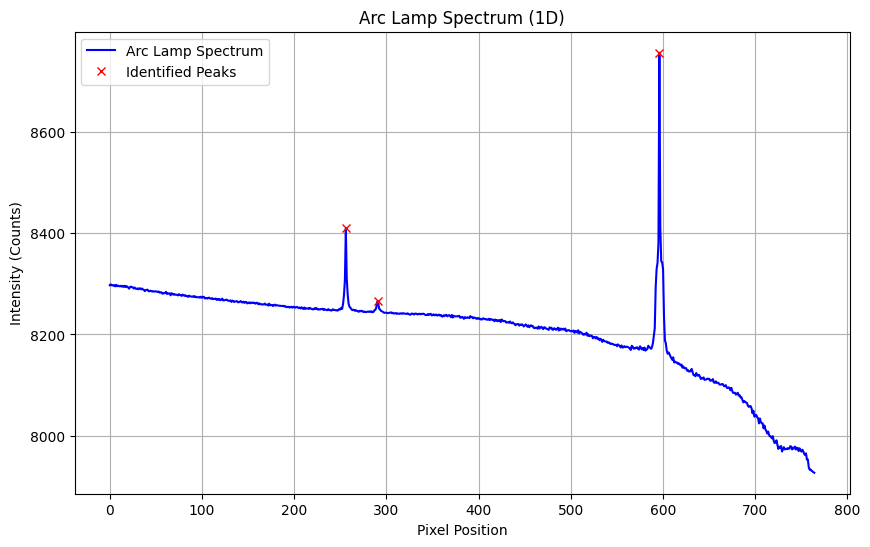

In [107]:
def analyze_arc_lamp_spectrum(corrected_median_arc_image, height_threshold=112, prominence_threshold=20):
    """
    Analyze the corrected arc lamp spectrum by collapsing it to 1D,
    identifying peaks based on height and prominence, and plotting the resulting spectrum.

    :param corrected_median_arc_image: 2D array containing the corrected arc lamp spectrum.
    :type corrected_median_arc_image: np.ndarray
    :param height_threshold: The height threshold for identifying peaks in the spectrum (default is 112).
    :type height_threshold: int, optional
    :param prominence_threshold: The minimum prominence for peaks (default is 20: DON'T CHANGE THIS).
    :type prominence_threshold: int, optional
    :return: 1D array of the arc lamp spectrum and indices of identified peaks.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Collapse the 2D arc lamp spectrum to 1D by taking the median along the spatial axis
    arc_lamp_spectrum_1d = np.median(corrected_median_arc_image, axis=0)
    # Identify peaks in the arc lamp spectrum using specified thresholds
    peak_indices, properties = find_peaks(arc_lamp_spectrum_1d, height=height_threshold, prominence=prominence_threshold)
    
    # Plot the arc lamp spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(arc_lamp_spectrum_1d, label='Arc Lamp Spectrum', color='blue')
    plt.plot(peak_indices, arc_lamp_spectrum_1d[peak_indices], 'rx', label='Identified Peaks')
    # Customize plot appearance
    plt.title('Arc Lamp Spectrum (1D)')
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid()
    plt.show()

    return arc_lamp_spectrum_1d, peak_indices

# Calling the function
arc_lamp_spectrum_1d, peak_indices = analyze_arc_lamp_spectrum(corrected_median_arc_image)

In [108]:
def print_peak_positions_with_intensities(arc_lamp_spectrum_1d, peak_indices):
    """
    Retrieve the pixel positions and corresponding intensities of the identified peaks in the 
    arc lamp spectrum.

    :param arc_lamp_spectrum_1d: 1D array containing the arc lamp spectrum.
    :type arc_lamp_spectrum_1d: np.ndarray
    :param peak_indices: 1D array containing the indices of the identified peaks.
    :type peak_indices: np.ndarray
    :return: A tuple of the peak pixel indices and corresponding intensities.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Extract the peak intensities at the identified peak indices
    peak_intensities = arc_lamp_spectrum_1d[peak_indices]
    return peak_indices, peak_intensities

# Calling the function
peak_indices, peak_intensities = print_peak_positions_with_intensities(arc_lamp_spectrum_1d, peak_indices)

# Displaying the results
for idx, intensity in zip(peak_indices, peak_intensities):
    print(f"Peak at pixel {idx}: Intensity = {intensity}")

Peak at pixel 256: Intensity = 8408.82588258447
Peak at pixel 291: Intensity = 8266.093945162364
Peak at pixel 596: Intensity = 8755.42048776968


Pixel Position | Wavelength (nm)
------------------------------
            256 |          404.77
            291 |          407.90
            596 |          435.95


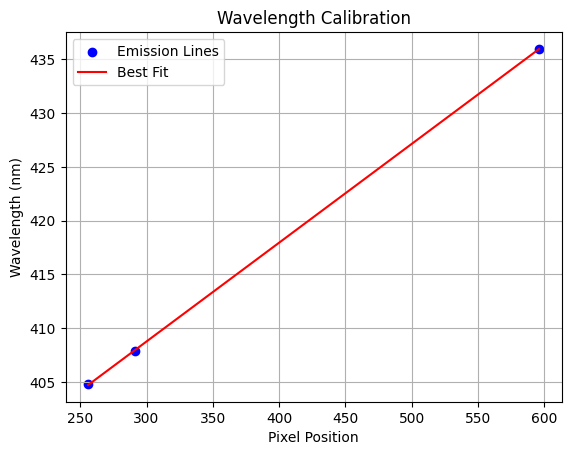

Linear Coefficients: Slope = 0.09182637598284521 nm, Intercept = 381.2218174172026 nm


In [109]:
def fit_wavelengths_to_peaks(peak_indices):
    """
    Fit the identified peak indices to known wavelengths, outputs table of pixel positions 
    and their wavelengths, and generates a calibration graph, returning the model coefficients.
    
    :param peak_indices: 1D array containing the indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    :return: A tuple containing the coefficients of the linear fit (slope, intercept).
    :rtype: tuple(float, float)
    """
    # Known wavelengths corresponding to the identified peaks in nanometers
    # known_wavelengths = [365.02, 404.66, 435.83]
    # known_wavelengths = [312,334,365]
    known_wavelengths = [404.77,407.898,435.955]
    # Ensure the number of peaks matches the number of known wavelengths
    if len(peak_indices) != len(known_wavelengths):
        raise ValueError("Number of identified peaks does not match the number of known wavelengths.")
    # Fit a linear model to the data
    linear_model = models.Linear1D()
    fitter = fitting.LinearLSQFitter()
    # Perform the fitting
    best_fit = fitter(linear_model, peak_indices, known_wavelengths)
    # Generate the table of pixel positions and wavelengths
    print("Pixel Position | Wavelength (nm)")
    print("-" * 30)
    for pixel_position, wavelength in zip(peak_indices, known_wavelengths):
        print(f"{pixel_position:15d} | {wavelength:15.2f}")

    # Plot the data and the best-fit linear line
    plt.scatter(peak_indices, known_wavelengths, color='blue', label='Emission Lines')
    plt.plot(np.sort(peak_indices), best_fit(np.sort(peak_indices)), color='red', label='Best Fit')
    plt.xlabel('Pixel Position')
    plt.ylabel('Wavelength (nm)')
    plt.title('Wavelength Calibration')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Output the linear coefficients
    coefficients = (best_fit.slope.value, best_fit.intercept.value)
    print(f"Linear Coefficients: Slope = {coefficients[0]} nm, Intercept = {coefficients[1]} nm")
    
    return coefficients

# Calling the function 
coefficients = fit_wavelengths_to_peaks(peak_indices)

In [110]:
def convert_dispersion_to_nanometers(object_flux, coefficients):
    """
    Convert the x-axis of the object flux from counts to nanometers.

    :param object_flux: 1D array containing the object flux (in intensity/counts).
    :type object_flux: np.ndarray
    :param coefficients: Coefficients of the linear fit for the conversion to nanometers.
    :type coefficients: tuple
    :return: wavelengths in nanometers and the converted object flux.
    :rtype: tuple (np.ndarray, np.ndarray)
    """
    # Extract linear coefficients: slope (a) and intercept (b)
    slope, intercept = coefficients  
    # Convert pixel positions to wavelengths (nanometers) using the linear fit
    pixel_positions = np.arange(len(object_flux))
    wavelengths = (slope * pixel_positions) + intercept

    return wavelengths, object_flux

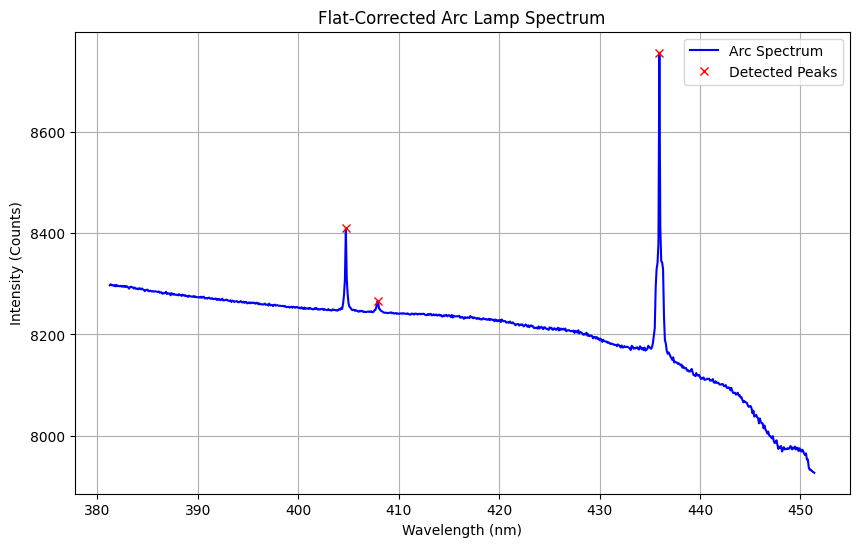

In [111]:
def process_arc_lamp_spectrum(arc_lamp_spectrum_1d, coefficients, peak_indices):
    """
    Process the arc lamp spectrum by converting to wavelengths and plotting the results.

    :param arc_lamp_spectrum_1d: 1D array containing the arc lamp spectrum (in intensity/counts).
    :type arc_lamp_spectrum_1d: np.ndarray
    :param coefficients: Coefficients of the linear fit for the conversion to nanometers.
    :type coefficients: tuple
    :param peak_indices: Indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    """
    # Convert the spectrum to wavelengths
    wavelengths, converted_spectrum = convert_dispersion_to_nanometers(arc_lamp_spectrum_1d, coefficients)
    # Plot the flat-corrected arc spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_spectrum, label='Arc Spectrum', color='blue')
    # Mark the peaks with an 'x' symbol
    plt.plot(wavelengths[peak_indices], converted_spectrum[peak_indices], 'x', color='red', label="Detected Peaks")
    # Set plot titles and labels
    plt.title('Flat-Corrected Arc Lamp Spectrum')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid()
    plt.show()

# Calling the functions 
process_arc_lamp_spectrum(arc_lamp_spectrum_1d, coefficients, peak_indices)
# The peaks aren't equal to [365.02, 404.66, 435.83] expected values but rather [381.007, 386.84, 437.665]

Section 2.1: Flux calibration

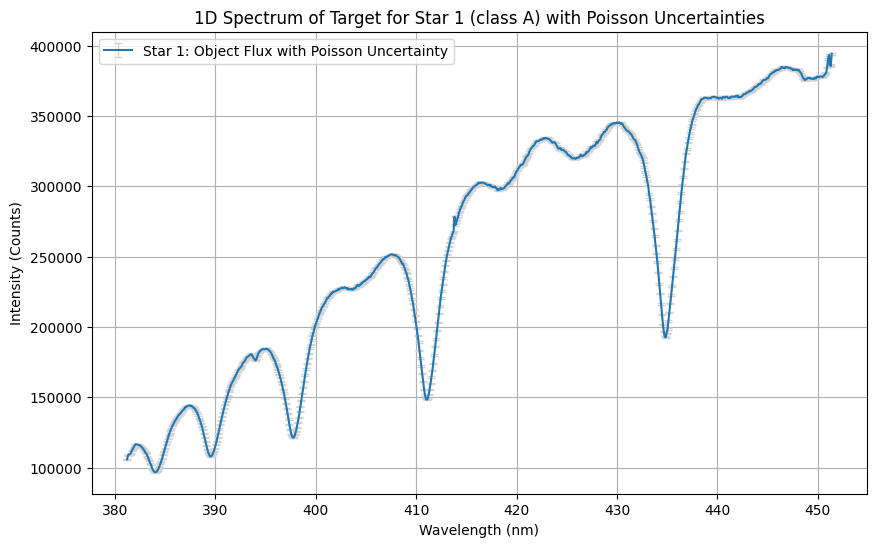

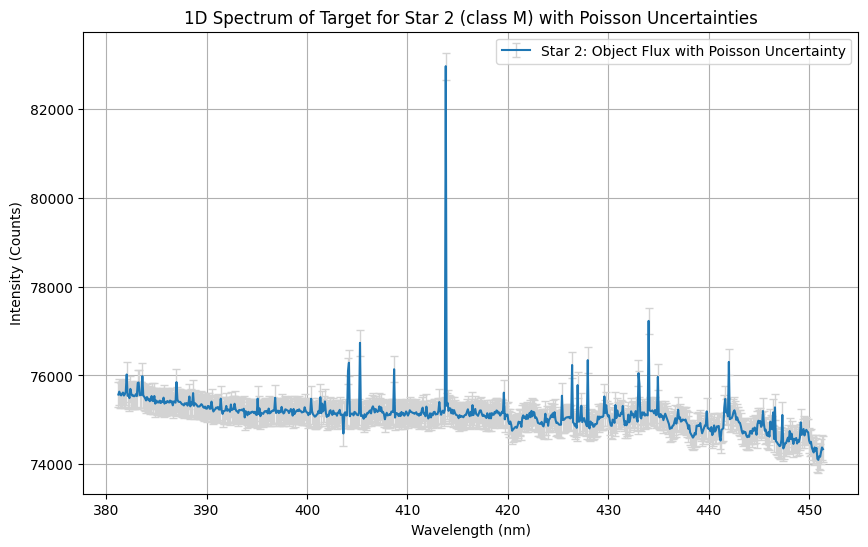

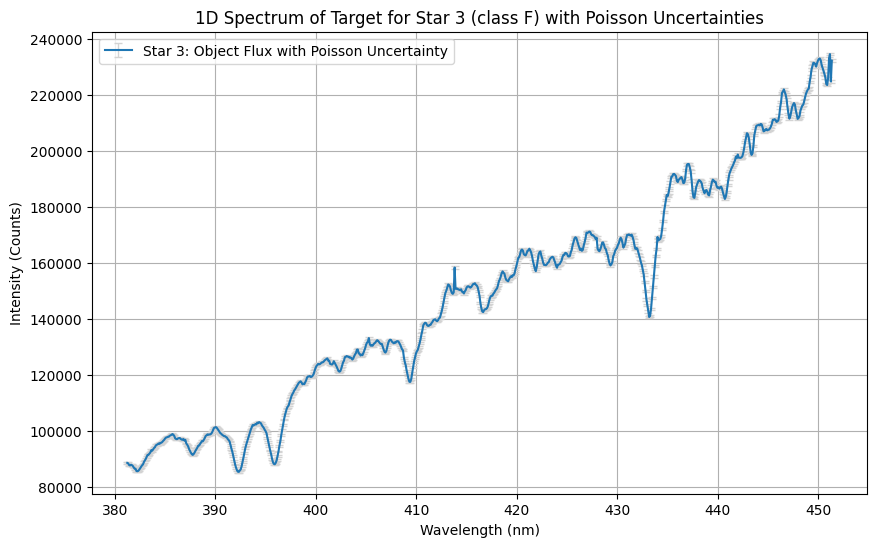

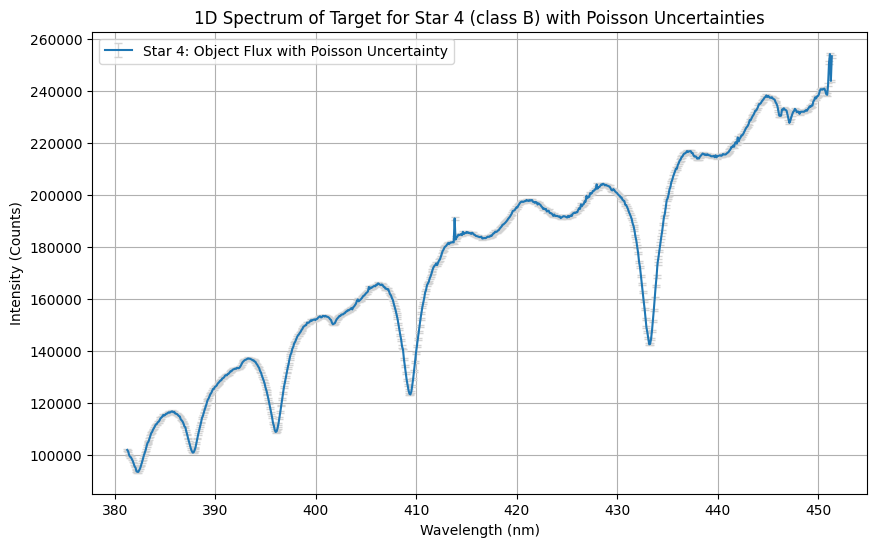

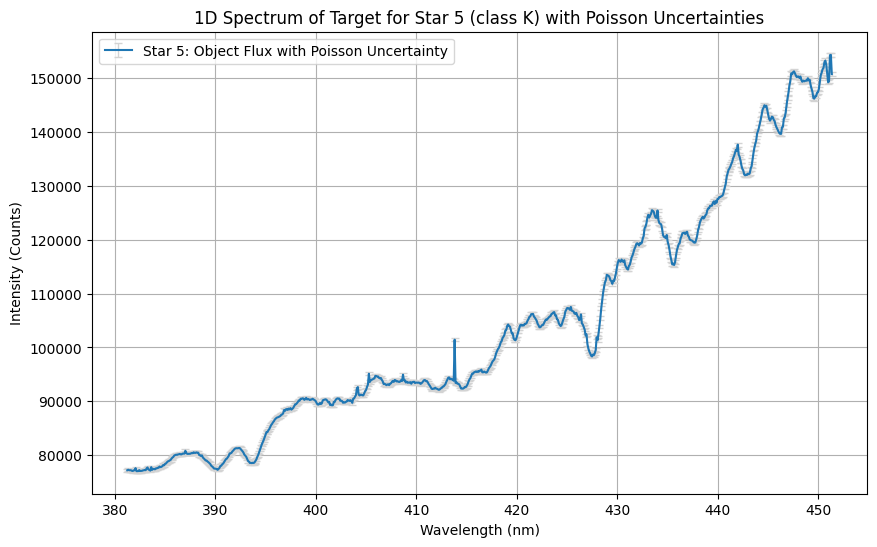

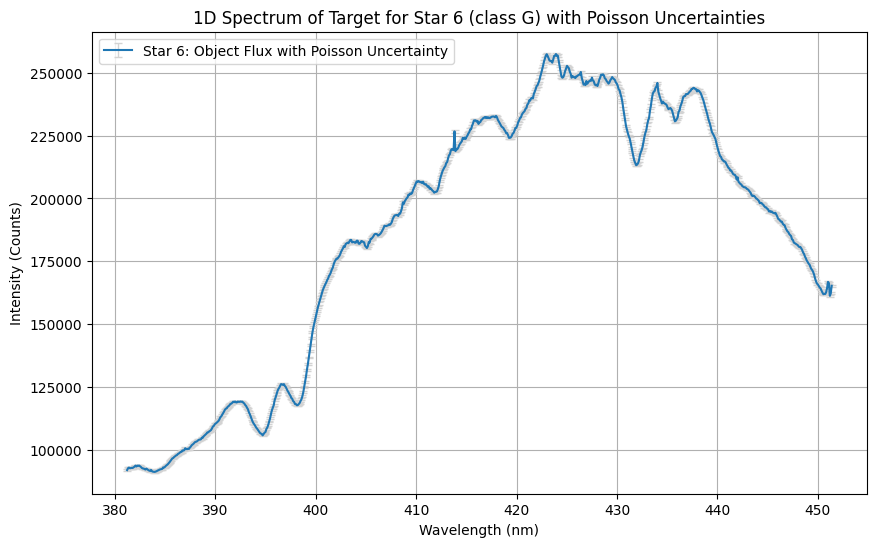

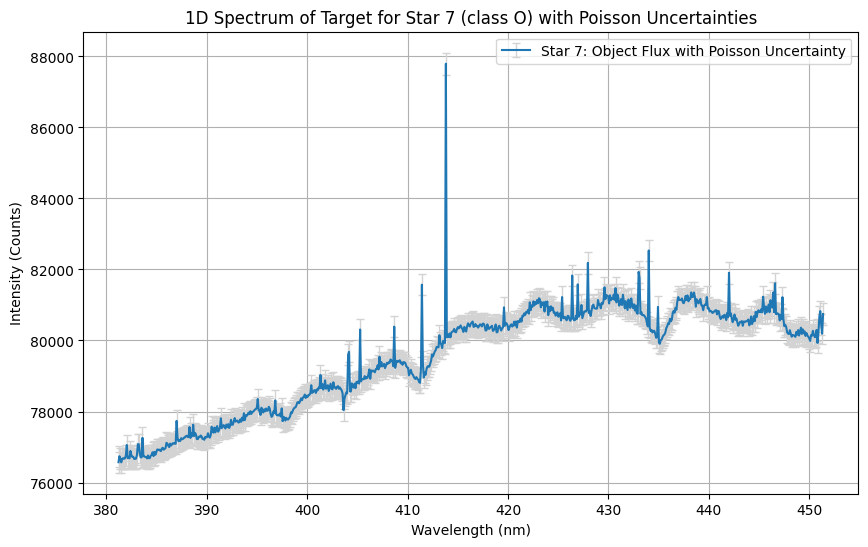

In [112]:
def process_star_spectra(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux_individual(corrected_image, star_index=0)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Plotting the object flux and its uncertainties for each star
        plt.figure(figsize=(10, 6))
        plt.errorbar(wavelengths, converted_object_flux, yerr=poisson_uncertainties, fmt='-', 
                     label=f'Star {i+1}: Object Flux with Poisson Uncertainty', 
                     ecolor='lightgray', elinewidth=1, capsize=3)  
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'1D Spectrum of Target for Star {i+1} (class {star_classes[i]}) with Poisson Uncertainties')
        plt.legend()
        plt.grid(True)
        plt.show()

process_star_spectra(corrected_spectra_images,coefficients)

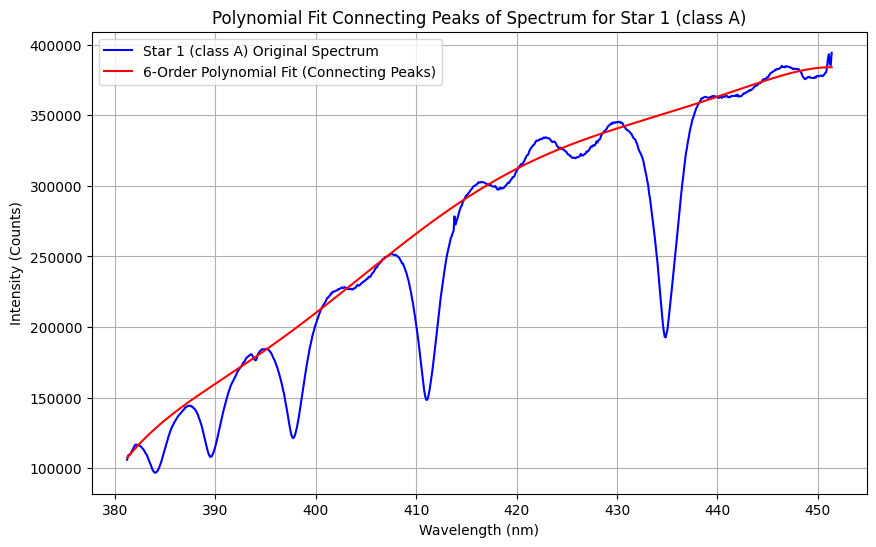

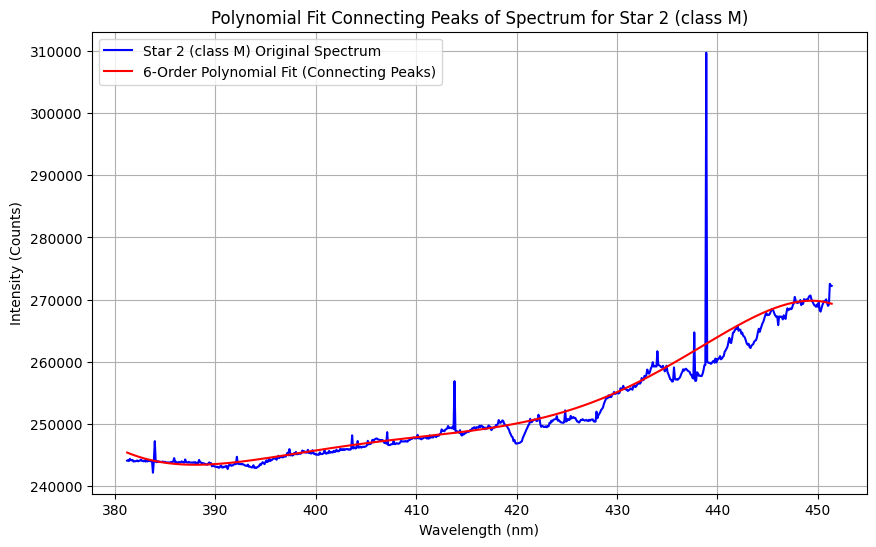

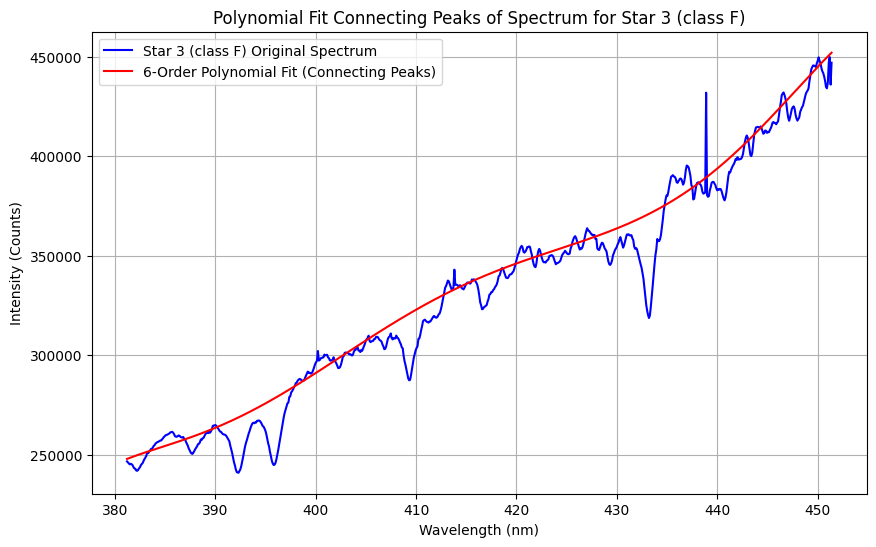

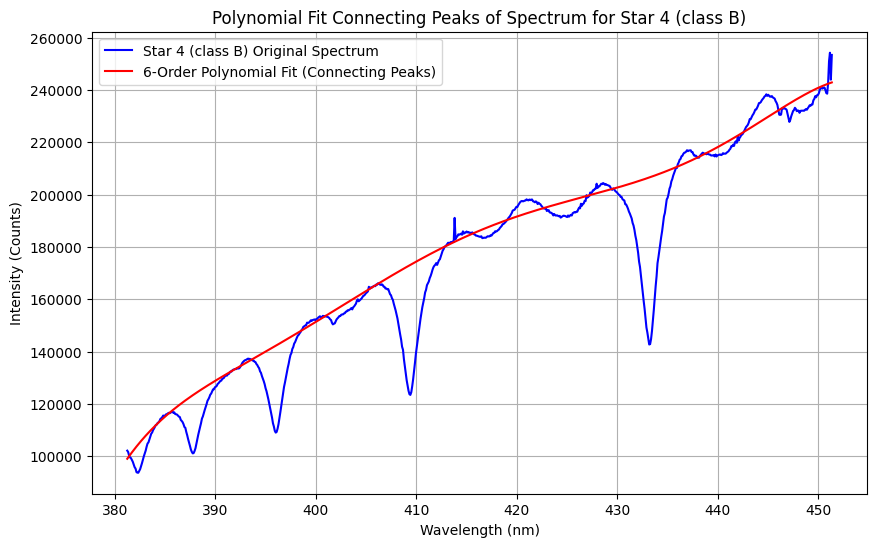

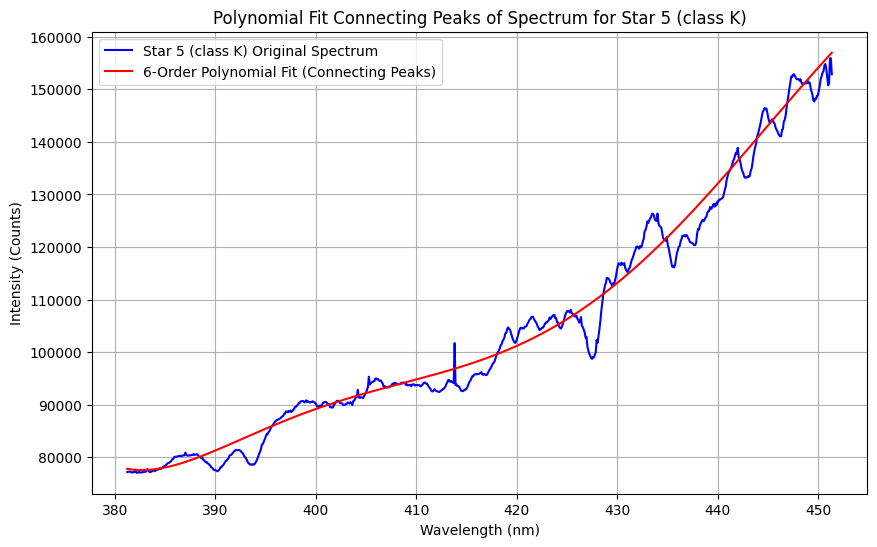

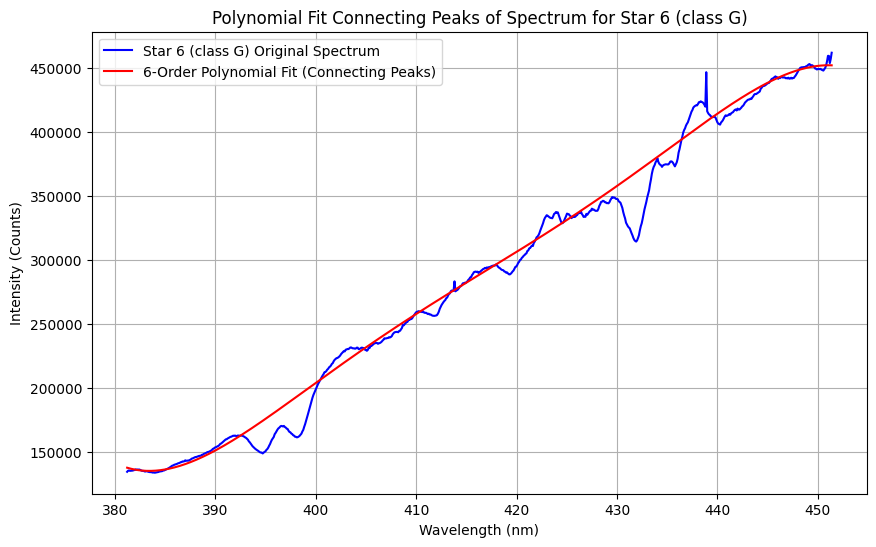

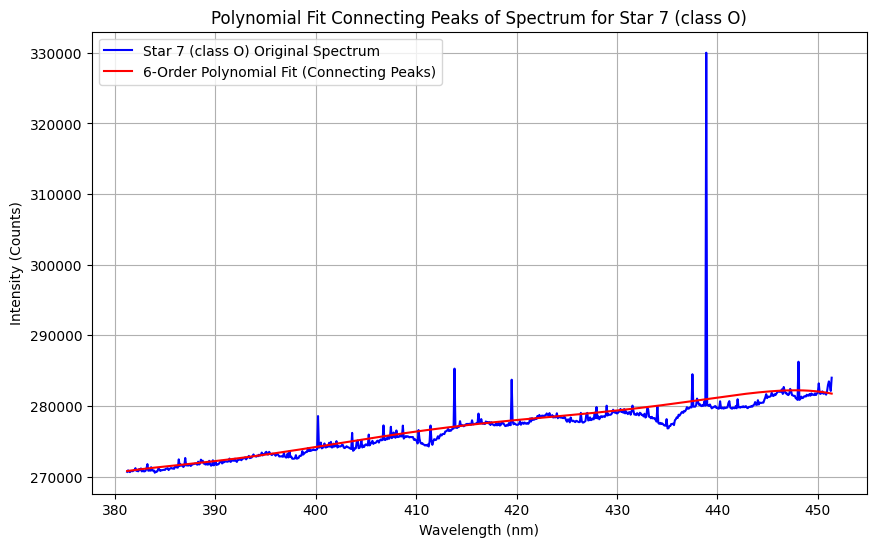

In [113]:
def process_star_spectra_all_interpolation(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
        
        # Identify peaks in the original spectrum
        peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
        peak_wavelengths = wavelengths[peak_indices]
        peak_fluxes = converted_object_flux[peak_indices]
        
        # Fit a polynomial to connect most of the peaks
        polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
        polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
        fit_values = polynomial_fit(wavelengths)
        
        # Plot the polynomial fit along with the original spectrum
        plt.figure(figsize=(10, 6))
        plt.plot(wavelengths, converted_object_flux, label=f'Star {i+1} (class {star_classes[i]}) Original Spectrum', color='blue')
        plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'Polynomial Fit Connecting Peaks of Spectrum for Star {i+1} (class {star_classes[i]})')
        plt.legend()
        plt.grid(True)
        plt.show()

process_star_spectra_all_interpolation(corrected_spectra_images, coefficients)


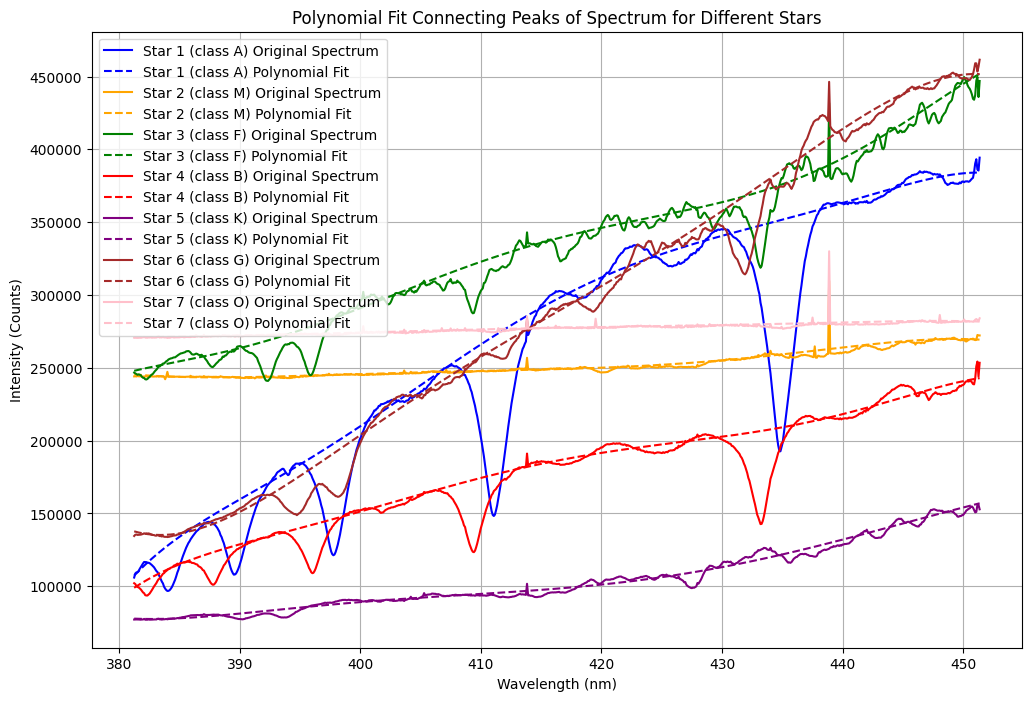

In [114]:
def process_star_spectra_all_in_one(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save plots for all stars on a single graph.
    
    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
    plt.figure(figsize=(12, 8))
    
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
        
        # Identify peaks in the original spectrum
        peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
        peak_wavelengths = wavelengths[peak_indices]
        peak_fluxes = converted_object_flux[peak_indices]
        
        # Fit a polynomial to connect most of the peaks
        polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
        polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
        fit_values = polynomial_fit(wavelengths)
        
        # Plot the polynomial fit along with the original spectrum
        plt.plot(wavelengths, converted_object_flux, label=f'Star {i+1} (class {star_classes[i]}) Original Spectrum', color=colors[i], linestyle='-')
        plt.plot(wavelengths, fit_values, label=f'Star {i+1} (class {star_classes[i]}) Polynomial Fit', color=colors[i], linestyle='--')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Polynomial Fit Connecting Peaks of Spectrum for Different Stars')
    plt.legend()
    plt.grid(True)
    plt.show()

process_star_spectra_all_in_one(corrected_spectra_images, coefficients)


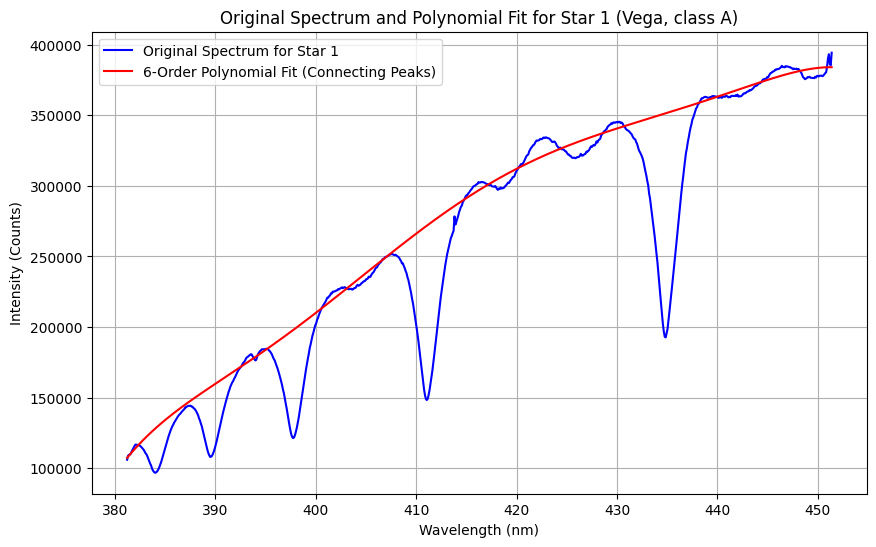

In [115]:
def process_star_spectra_Vega_Peaks_fit(corrected_spectra_images, coefficients):
    """
    Process the corrected spectra image of the first star, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Process only the first star's corrected spectra image
    corrected_image = corrected_spectra_images[0]
    
    # Extract object and sky flux
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=0)
    # Calculate Poisson uncertainties
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
    # Convert to wavelengths (nm)
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Plot both the original curve and the polynomial fit for Star 1
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 1', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Original Spectrum and Polynomial Fit for Star 1 (Vega, class A)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return wavelengths, converted_object_flux

# Call the function to get wavelengths and flux for the reference star
wavelengths, converted_object_flux = process_star_spectra_Vega_Peaks_fit(corrected_spectra_images, coefficients)


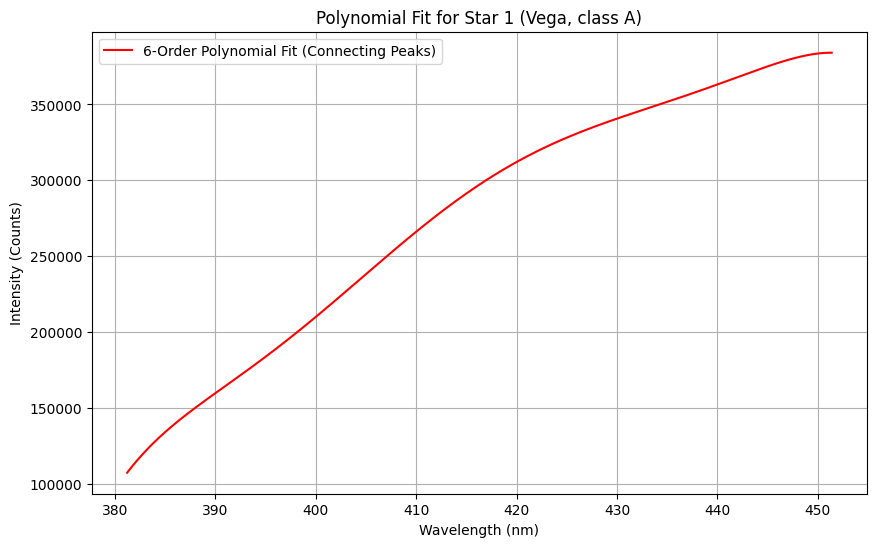

In [116]:
def calculate_polynomial_fit_vega(corrected_spectra_images, coefficients, degree=6):
    """
    Calculate and produce only the polynomial fit of the first reference star, Vega.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :return: Polynomial fit values over the wavelength range of the spectrum.
    :rtype: np.ndarray
    """
    # Process only the first star's corrected spectra image (Vega)
    corrected_image = corrected_spectra_images[0]
    
    # Extract object and sky flux for Vega
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=0)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Plot the polynomial fit for Vega
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Polynomial Fit for Star 1 (Vega, class A)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return fit_values

# Call the function to calculate and produce the polynomial fit for Vega
fit_values = calculate_polynomial_fit_vega(corrected_spectra_images, coefficients)


In [117]:

def calculate_blackbody_spectrum(wavelengths, temperature=9602):
    """
    Calculate and plot the blackbody spectrum for a given temperature.

    :param wavelengths: Wavelengths in nanometers to calculate the blackbody spectrum.
    :type wavelengths: np.ndarray
    :param temperature: Temperature of the blackbody in Kelvin (default is 9602 K).
    :type temperature: float
    :return: The blackbody flux values at the given wavelengths.
    :rtype: np.ndarray
    """
    # Convert wavelengths from nm to meters
    wavelengths_m = wavelengths * 1e-9

    # Calculate blackbody flux using Planck's law
    exponent = (h * c) / (wavelengths_m * k * temperature)
    blackbody_flux = (2 * h * c**2) / (wavelengths_m**5 * (np.exp(exponent) - 1))

    # Plot the blackbody spectrum
    # plt.figure(figsize=(10, 6))
    # plt.plot(wavelengths, blackbody_flux, color='blue', label=f'Blackbody Spectrum at {temperature} K')
    # plt.xlabel('Wavelength (nm)')
    # plt.ylabel('Flux (arbitrary units)')
    # plt.title(f'Blackbody Spectrum at {temperature} K')
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    return blackbody_flux

# Example usage
wavelengths = np.linspace(380,460, 1000)  # Wavelengths from 100 nm to 3000 nm
blackbody_flux = calculate_blackbody_spectrum(wavelengths)


<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
C:\Users\sunyx\AppData\Local\Temp\ipykernel_16748\2499017052.py:42: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(wavelengths, d_lambda, label='$d_{\lambda}$ Curve', color='green')
C:\Users\sunyx\AppData\Local\Temp\ipykernel_16748\2499017052.py:44: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$d_{\lambda}$ (Blackbody / Polynomial Fit)')
C:\Users\sunyx\AppData\Local\Temp\ipykernel_16748\2499017052.py:45: SyntaxWarning: invalid escape sequence '\l'
  plt.title('$d_{\lambda}$ Curve for Vega (T = 9602 K)')


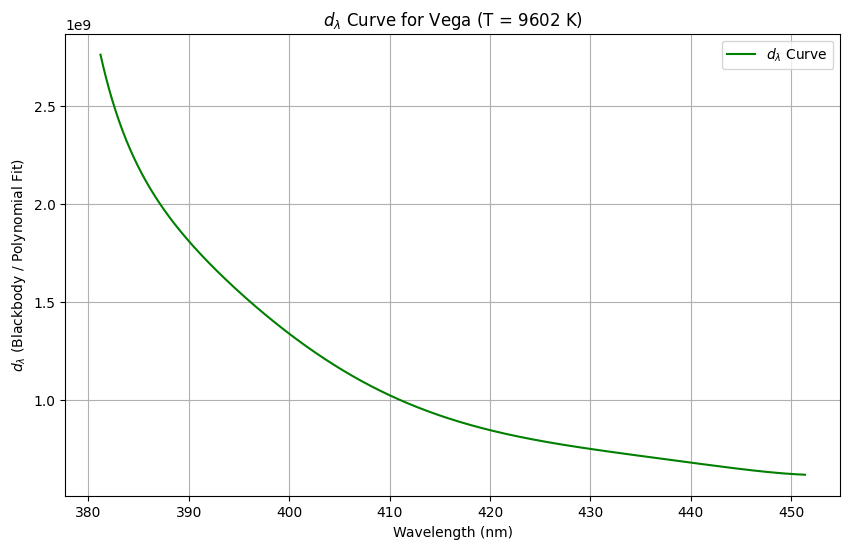

In [118]:
def calculate_d_lambda_curve(blackbody_temperature, corrected_spectra_images, coefficients, degree=6):
    """
    Calculate and generate a curve d_lambda by dividing the blackbody spectrum at a given temperature by the polynomial fit of Vega's spectrum.

    :param blackbody_temperature: Temperature of the blackbody in Kelvin.
    :type blackbody_temperature: float
    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :return: Wavelengths and d_lambda values.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Process only the first star's corrected spectra image (Vega)
    corrected_image = corrected_spectra_images[0]
    
    # Extract object and sky flux for Vega
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=0)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the blackbody spectrum
    blackbody_flux = calculate_blackbody_spectrum(wavelengths, blackbody_temperature)
    
    # Calculate d_lambda by dividing the blackbody flux by the polynomial fit values
    d_lambda = blackbody_flux / fit_values
    
    # Plot the d_lambda curve
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, d_lambda, label='$d_{\lambda}$ Curve', color='green')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$d_{\lambda}$ (Blackbody / Polynomial Fit)')
    plt.title('$d_{\lambda}$ Curve for Vega (T = 9602 K)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return wavelengths, d_lambda

# Call the function to calculate d_lambda
wavelengths, d_lambda = calculate_d_lambda_curve(9602, corrected_spectra_images, coefficients)



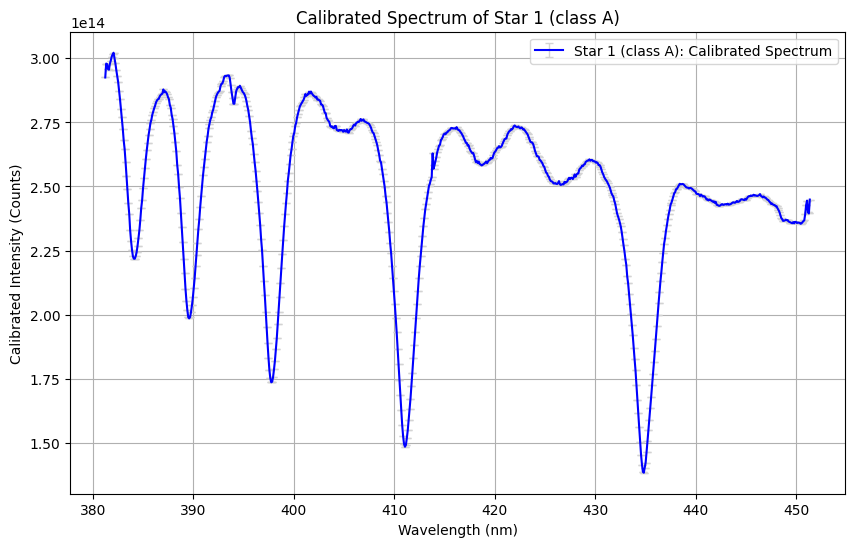

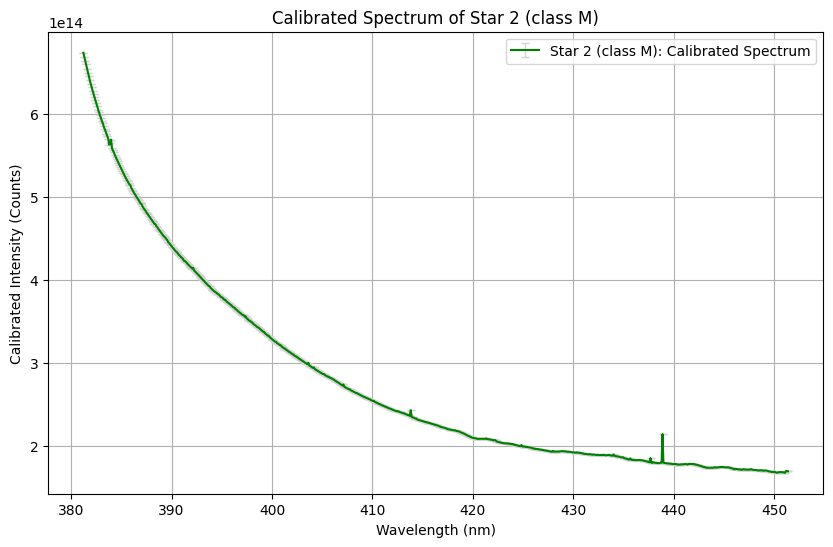

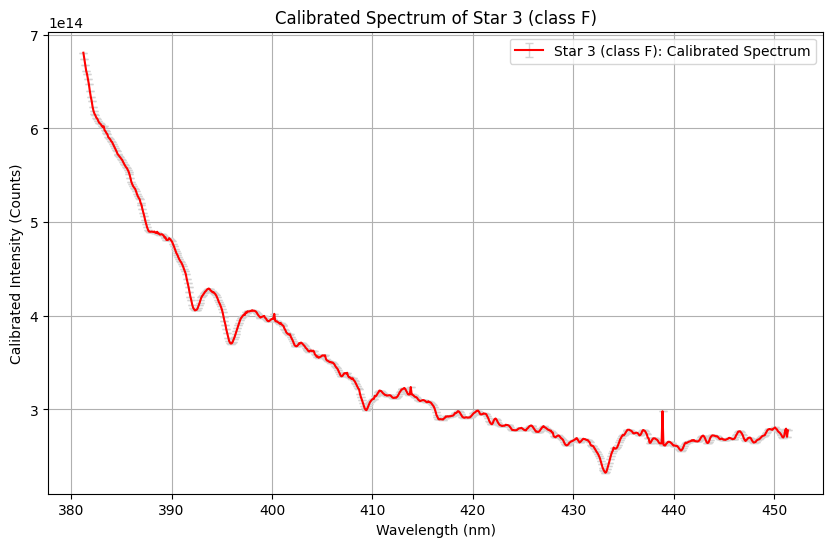

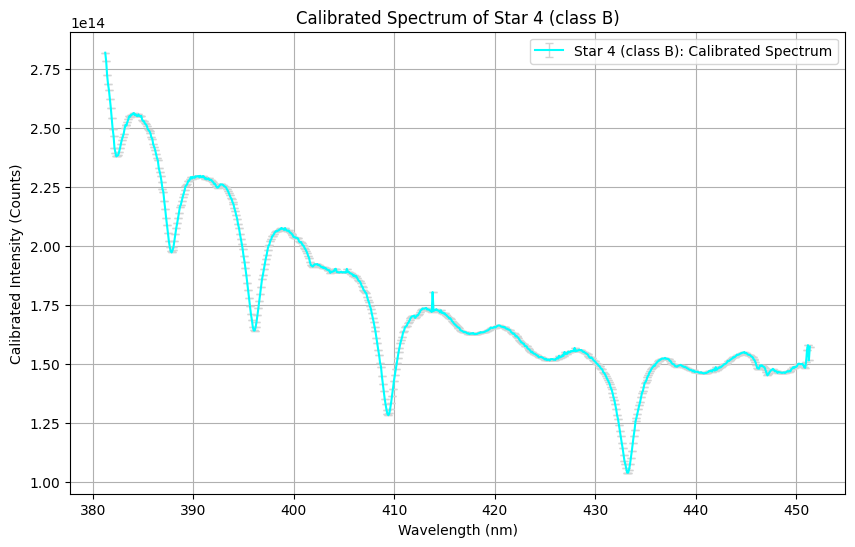

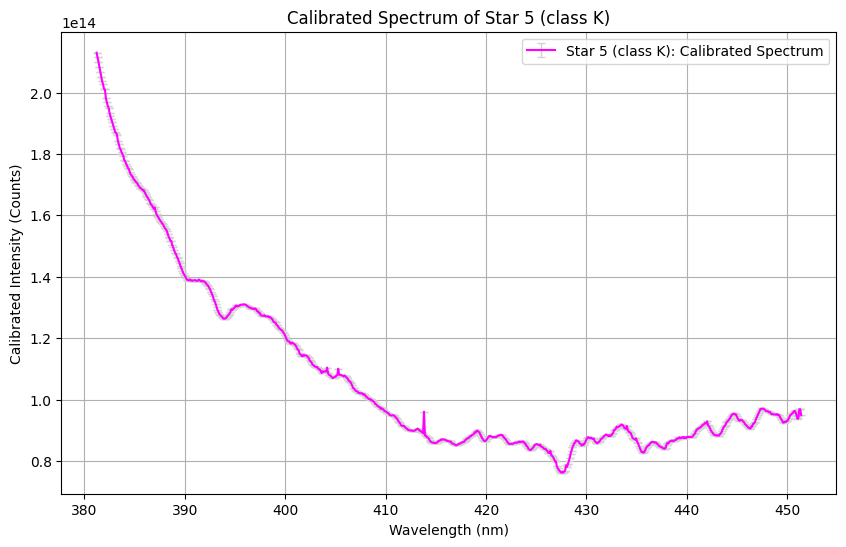

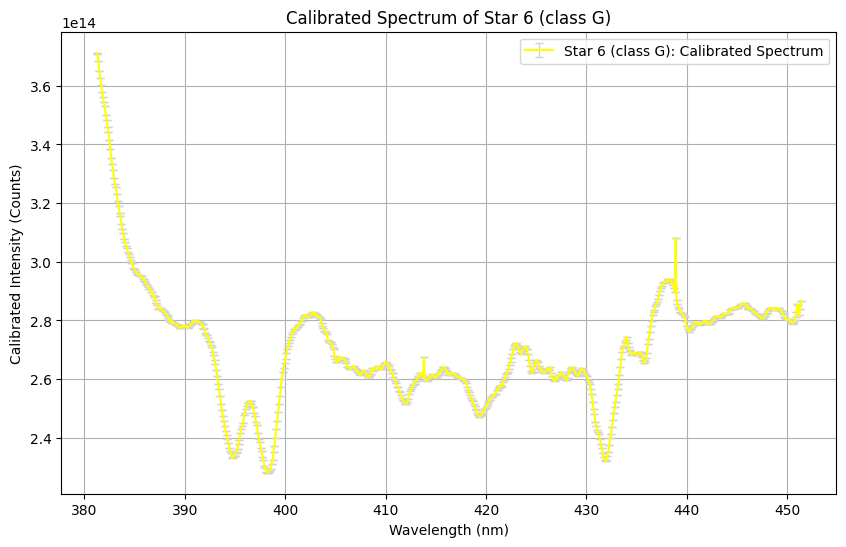

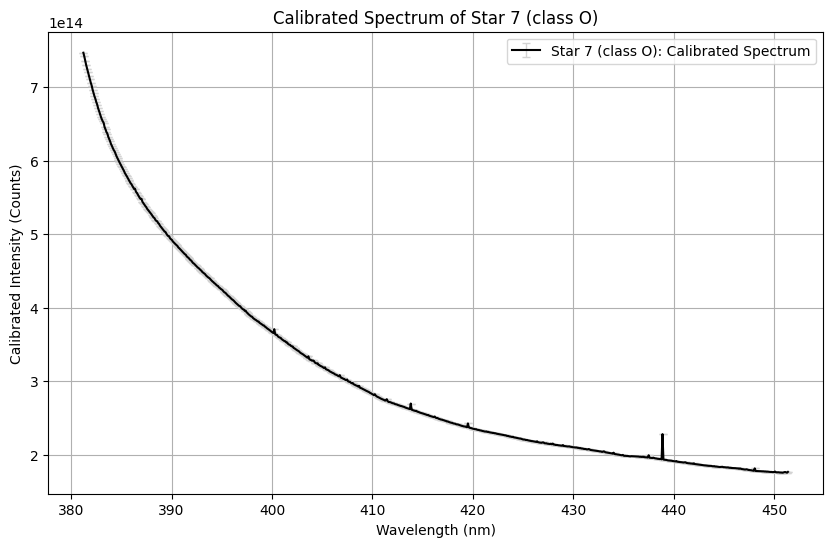

In [119]:
def calibrate_star_spectra(corrected_spectra_images, coefficients, wavelengths_d_lambda, d_lambda_values):
    """
    Calibrate each star's spectrum by multiplying it with the d_lambda curve.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param wavelengths_d_lambda: Wavelengths corresponding to the d_lambda values.
    :type wavelengths_d_lambda: np.ndarray
    :param d_lambda_values: The d_lambda values for calibration.
    :type d_lambda_values: np.ndarray
    :return: Wavelengths and calibrated object flux for each star.
    :rtype: list of tuples (np.ndarray, np.ndarray)
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    calibrated_spectra = []
    
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux for each star
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
        
        # Interpolate d_lambda to match the length of converted_object_flux
        interpolation_function = interp1d(wavelengths_d_lambda, d_lambda_values, kind='linear', fill_value='extrapolate')
        interpolated_d_lambda = interpolation_function(wavelengths)
        
        # Multiply the object flux by d_lambda to get the calibrated spectrum
        calibrated_object_flux = converted_object_flux * interpolated_d_lambda
        calibrated_spectra.append((wavelengths, calibrated_object_flux))
        
        # Plotting the calibrated spectrum for each star
        plt.figure(figsize=(10, 6))
        plt.errorbar(wavelengths, calibrated_object_flux, yerr=poisson_uncertainties, fmt='-', 
                     label=f'Star {i+1} (class {star_classes[i]}): Calibrated Spectrum', 
                     ecolor='lightgray', elinewidth=1, capsize=3, color=f'{colors[i]}')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Calibrated Intensity (Counts)')
        plt.title(f'Calibrated Spectrum of Star {i+1} (class {star_classes[i]})')
        plt.legend()
        plt.grid(True)
        plt.show()

    return calibrated_spectra

# Call the function to get calibrated spectra for all stars
calibrated_spectra = calibrate_star_spectra(corrected_spectra_images, coefficients, wavelengths, d_lambda)



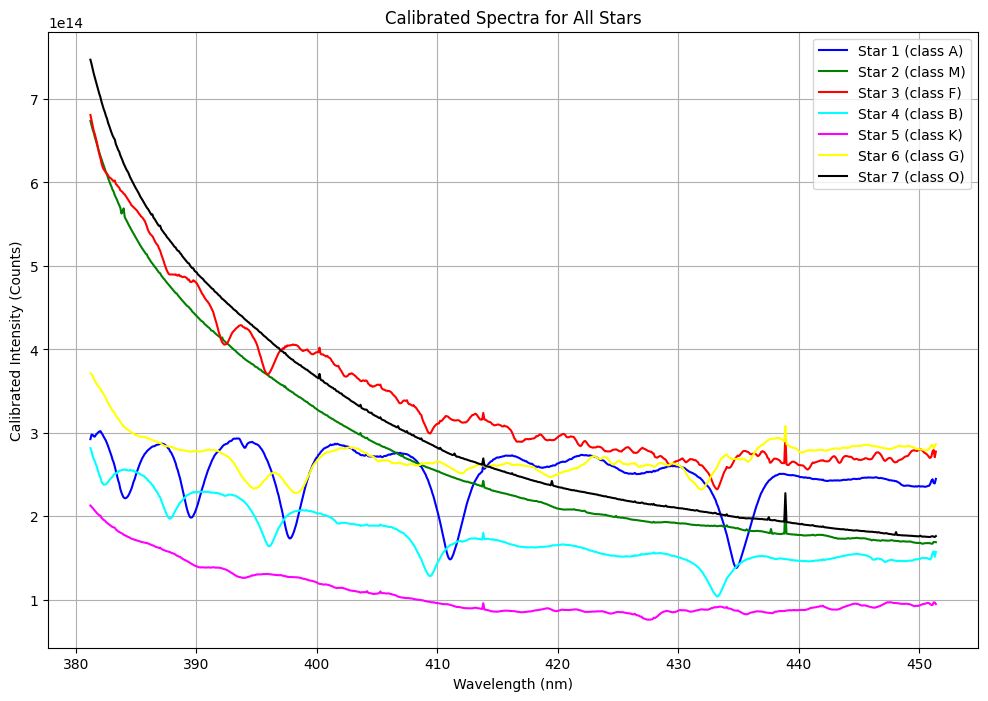

In [120]:
def process_and_plot_all_stars_calibrated_spectra(corrected_spectra_images, coefficients, wavelengths, d_lambda):
    """
    Process each star's corrected spectra image, multiply by the d_lambda curve,
    and plot all calibrated spectra on a single graph.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param wavelengths: Wavelengths in nanometers corresponding to the d_lambda curve.
    :type wavelengths: np.ndarray
    :param d_lambda: d_lambda values for flux calibration.
    :type d_lambda: np.ndarray
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

    plt.figure(figsize=(12, 8))
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=i)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        star_wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Interpolate d_lambda to match the length of converted_object_flux
        interpolation_function = interp1d(wavelengths, d_lambda, kind='linear', fill_value='extrapolate')
        interpolated_d_lambda = interpolation_function(star_wavelengths)

        # Multiply the object flux by d_lambda for calibration
        calibrated_object_flux = converted_object_flux * interpolated_d_lambda

        # Plotting the calibrated spectrum for each star
        plt.plot(star_wavelengths, calibrated_object_flux, label=f'Star {i+1} (class {star_classes[i]})', color=colors[i])

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Calibrated Intensity (Counts)')
    plt.title('Calibrated Spectra for All Stars')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calling the function to process and plot all stars' calibrated spectra
process_and_plot_all_stars_calibrated_spectra(corrected_spectra_images, coefficients, wavelengths, d_lambda)



3.1: Gaussian profile to each emission line

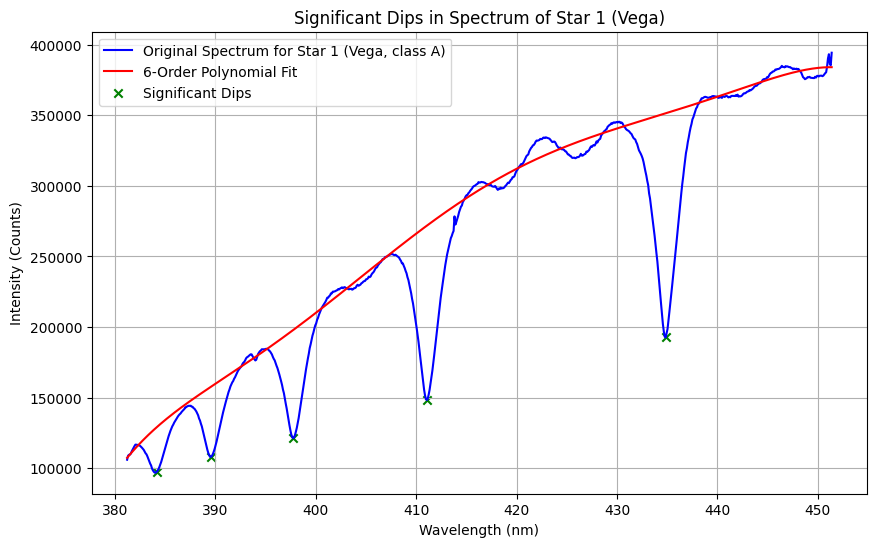

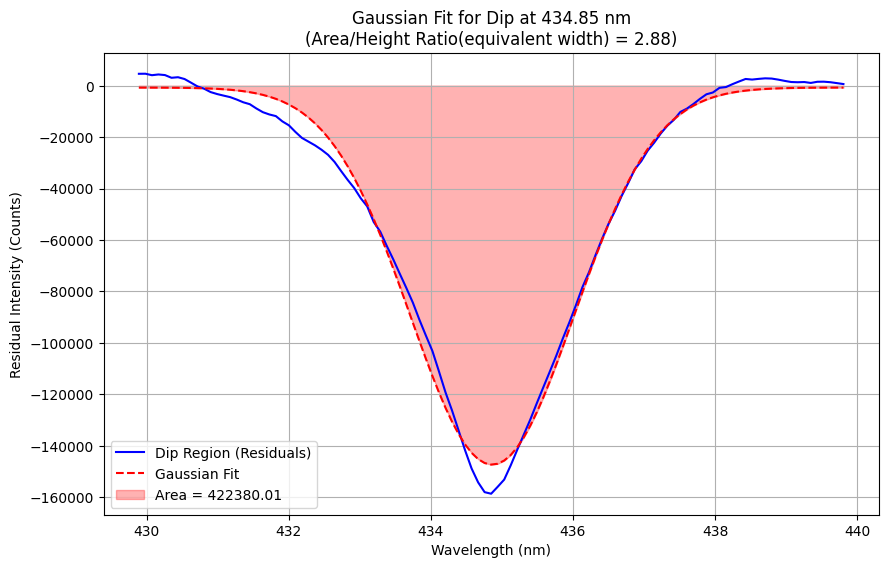

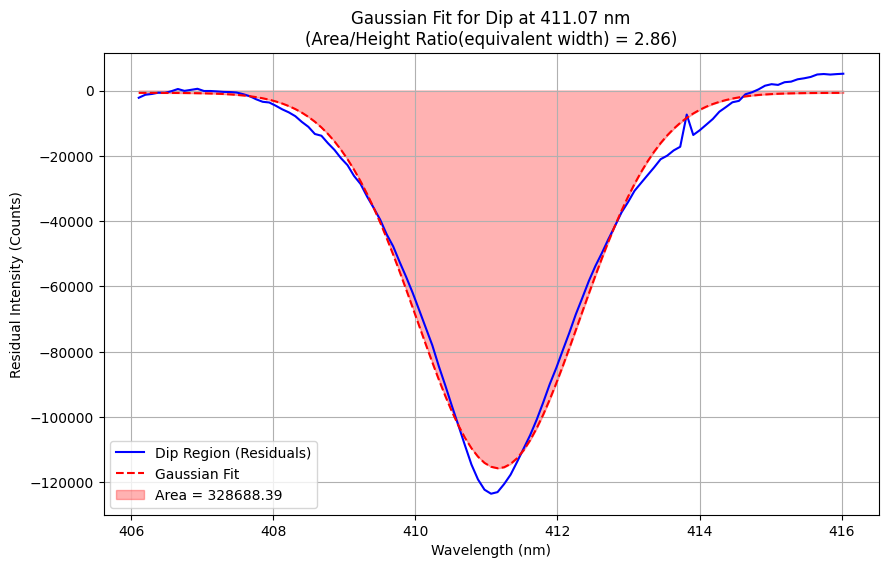

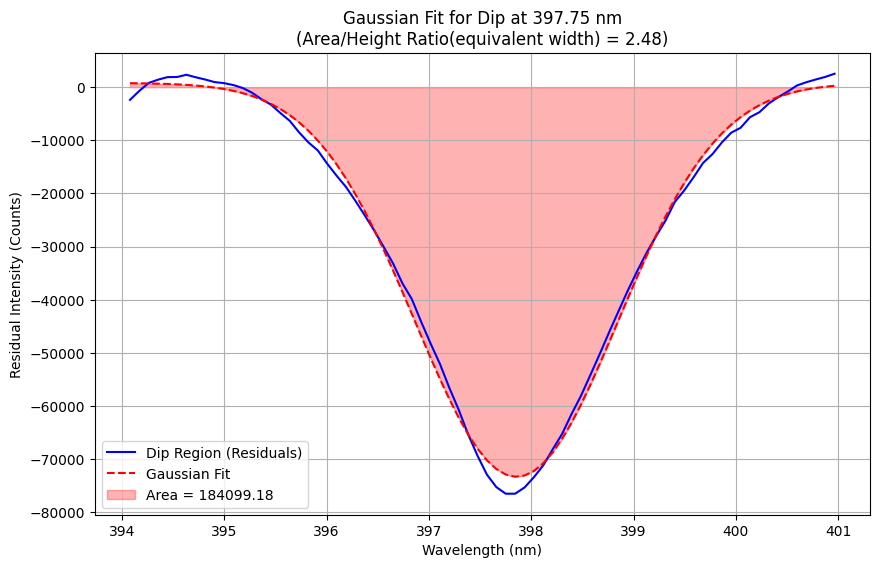

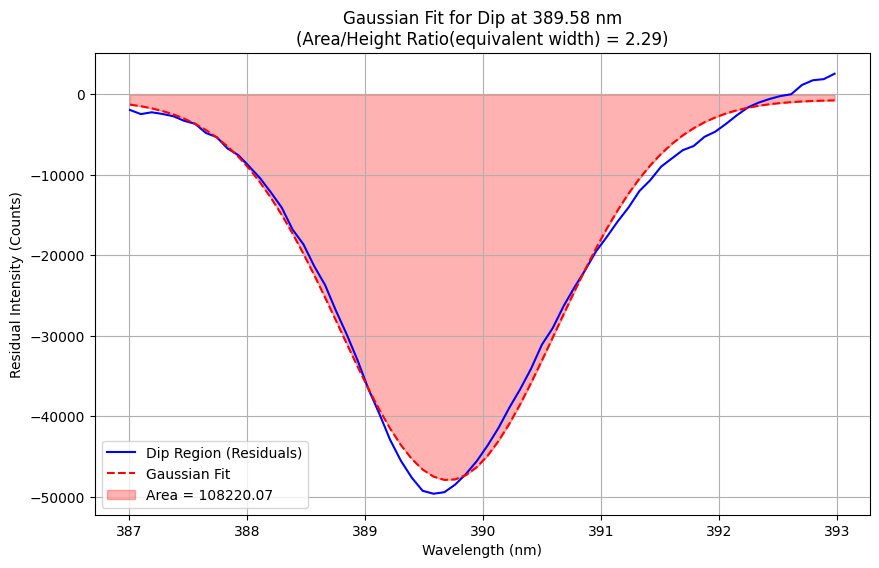

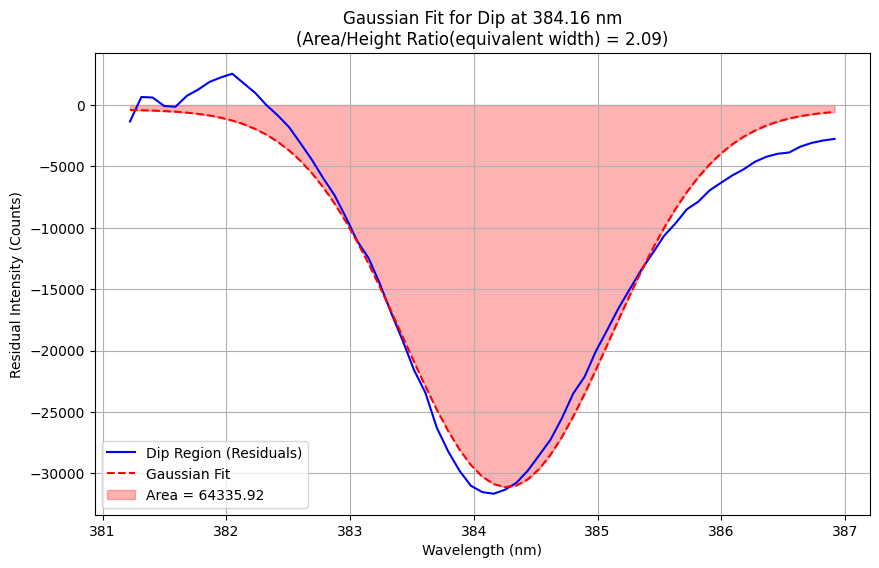

In [121]:
def identify_and_fit_gaussian_to_dips_A_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450), num_dips=5):
    """
    Identify the most significant dips in the spectrum of the first reference star (Vega),
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    :param num_dips: Number of most significant dips to identify (default is 5).
    :type num_dips: int
    """
    # Process only the first star's corrected spectra image (Vega)
    corrected_image = corrected_spectra_images[0]
    
    # Extract object and sky flux for Vega
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=0)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Select the most significant dips (lowest values)
    sorted_indices = np.argsort(dip_fluxes)[:num_dips]
    significant_dip_wavelengths = dip_wavelengths[sorted_indices]
    significant_dip_fluxes = dip_fluxes[sorted_indices]

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 1 (Vega, class A)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, converted_object_flux[dip_indices][sorted_indices], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 1 (Vega)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point (e.g., ±5 nm for fitting)
        
        if np.isclose(dip_wavelength, 384.16, atol=0.1):  # Use np.isclose to avoid floating-point precision issues
            start, end = 381, 387  # Specific range for the dip at 384.16 nm
        elif np.isclose(dip_wavelength, 389.58, atol=0.1):  # Use np.isclose to avoid floating-point precision issues
            start, end = 387, 393  # Specific range for the dip at 389.58 nm
        elif np.isclose(dip_wavelength, 397.75, atol=0.1):  # Use np.isclose to avoid floating-point precision issues
            start, end = 394, 401  # Specific range for the dip at 389.58 nm
        else:
            start, end = dip_wavelength - 5, dip_wavelength + 5
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='red', alpha=0.3, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm\n(Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

identify_and_fit_gaussian_to_dips_A_star(corrected_spectra_images, coefficients)



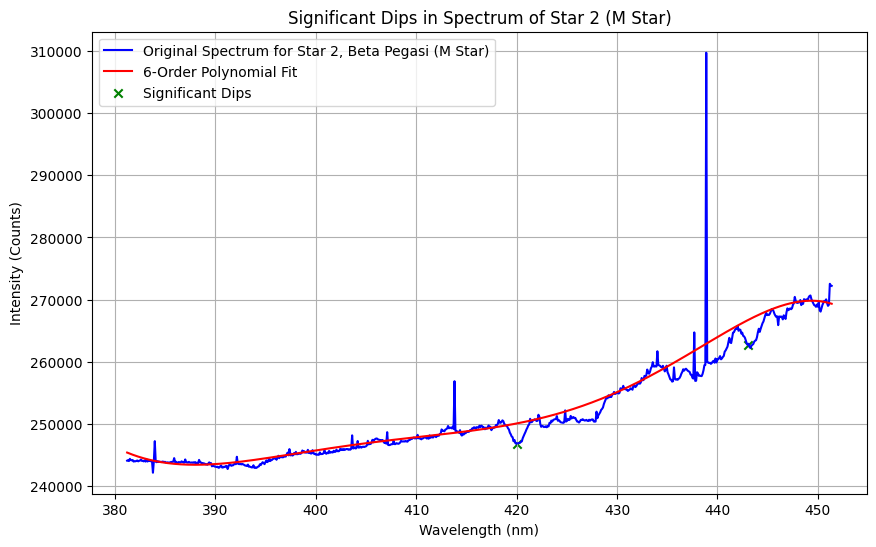

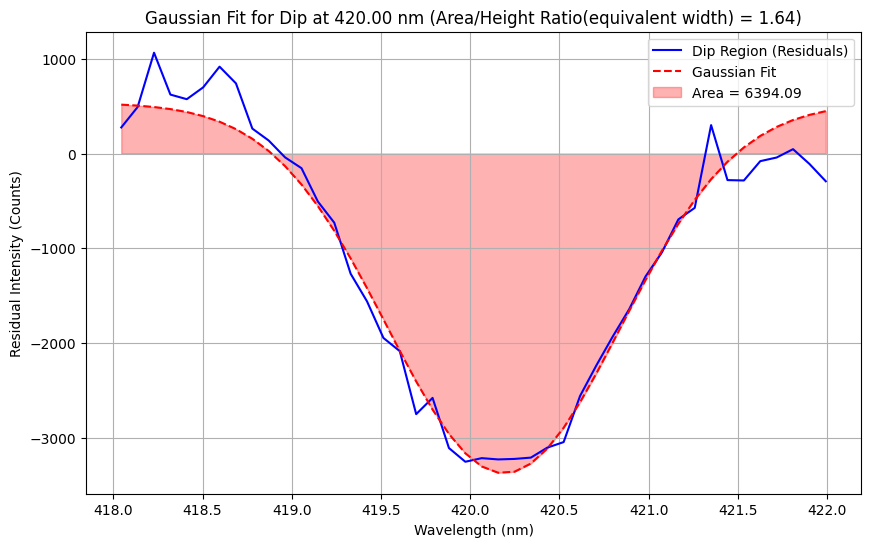

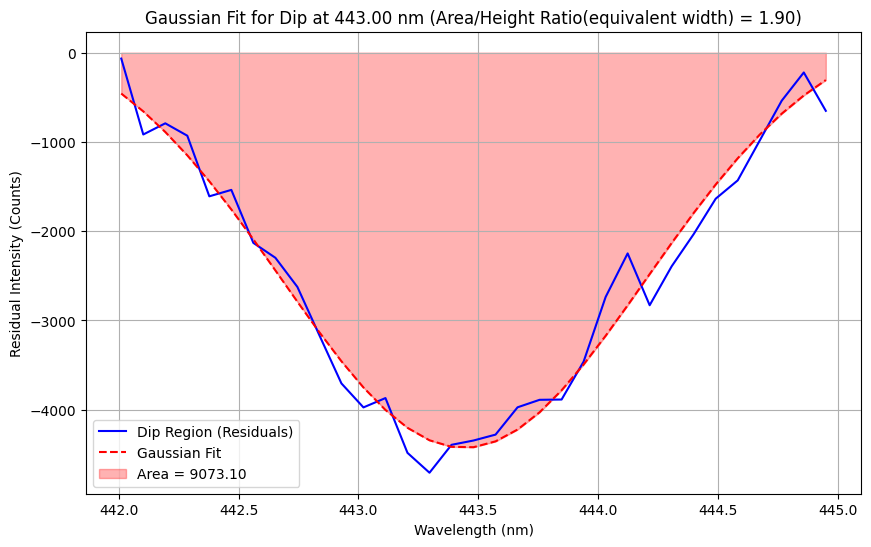

In [122]:
def identify_and_fit_gaussian_to_dips_M_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450)):
    """
    Identify the significant dips in the spectrum of the M star,
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    """
    # Process only the second star's corrected spectra image (M star)
    corrected_image = corrected_spectra_images[1]
    
    # Extract object and sky flux for the M star
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=1)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Manually select the two significant dips for the M star
    significant_dip_wavelengths = [420, 443]  # Approximate positions of the dips in nm
    significant_dip_fluxes = []

    for wavelength in significant_dip_wavelengths:
        closest_index = np.argmin(np.abs(dip_wavelengths - wavelength))
        significant_dip_fluxes.append(dip_fluxes[closest_index])

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 2, Beta Pegasi (M Star)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, [converted_object_flux[dip_indices[np.argmin(np.abs(dip_wavelengths - wavelength))]] for wavelength in significant_dip_wavelengths], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 2 (M Star)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point
        if dip_wavelength == 443:
            start, end = 442, 445  # Specific range for the dip at 443 nm
        else:
            start, end = dip_wavelength - 2, dip_wavelength + 2
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='red', alpha=0.3, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm (Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to identify and fit Gaussians to the dips in the M star spectrum
identify_and_fit_gaussian_to_dips_M_star(corrected_spectra_images, coefficients)




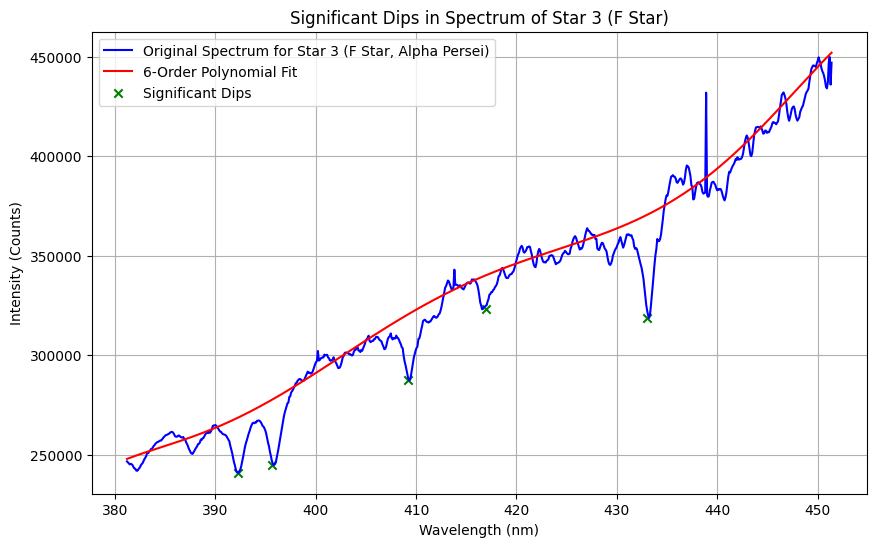

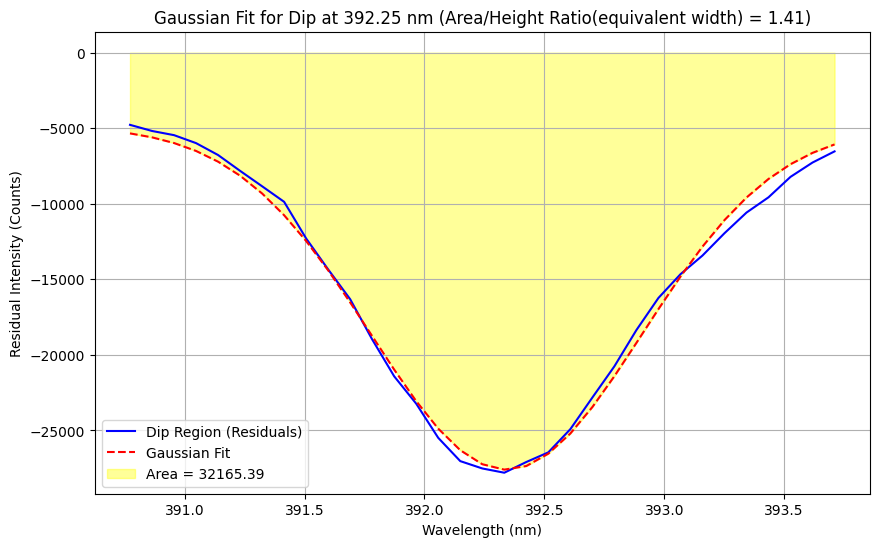

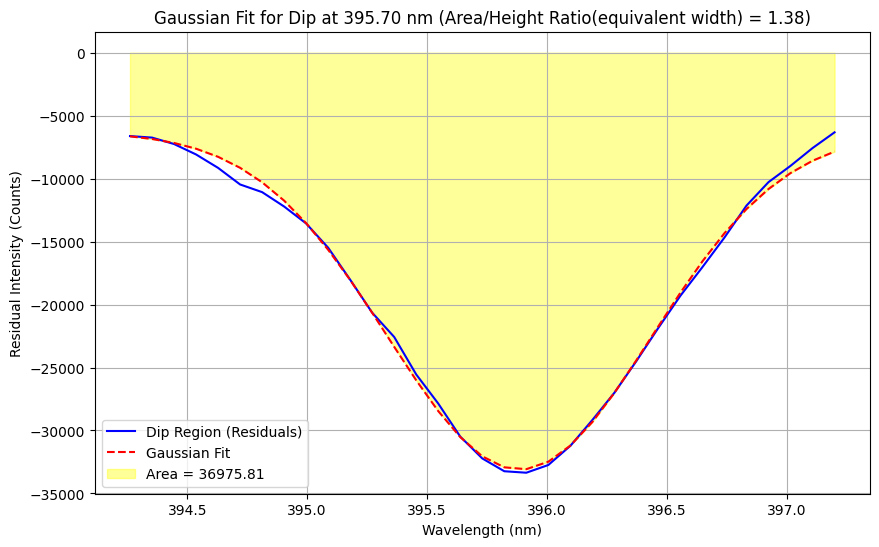

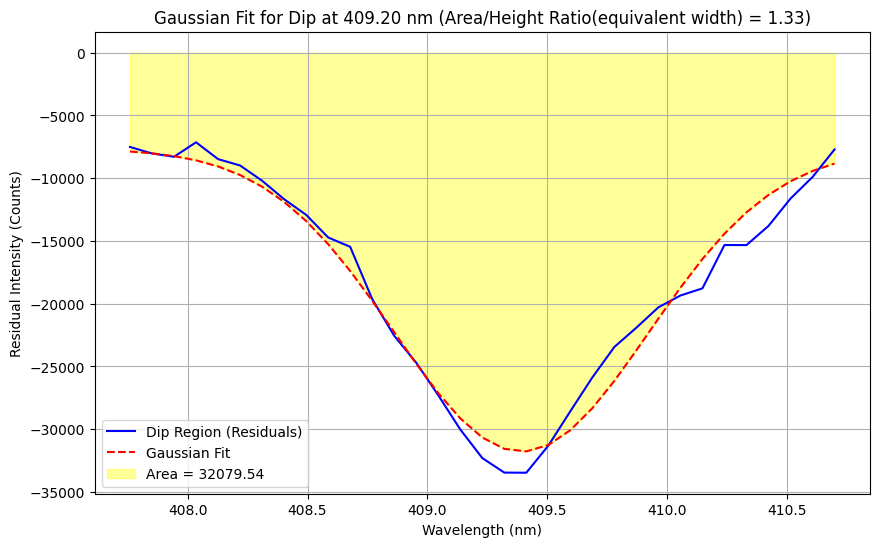

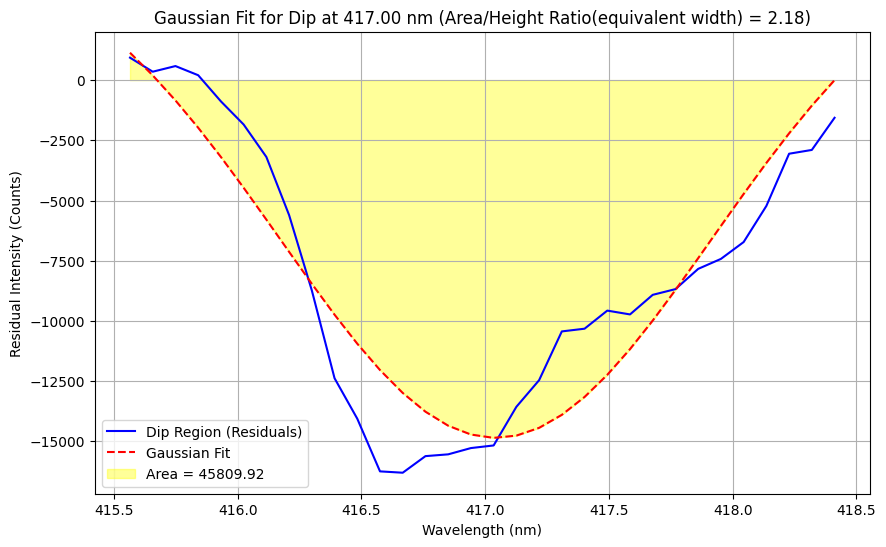

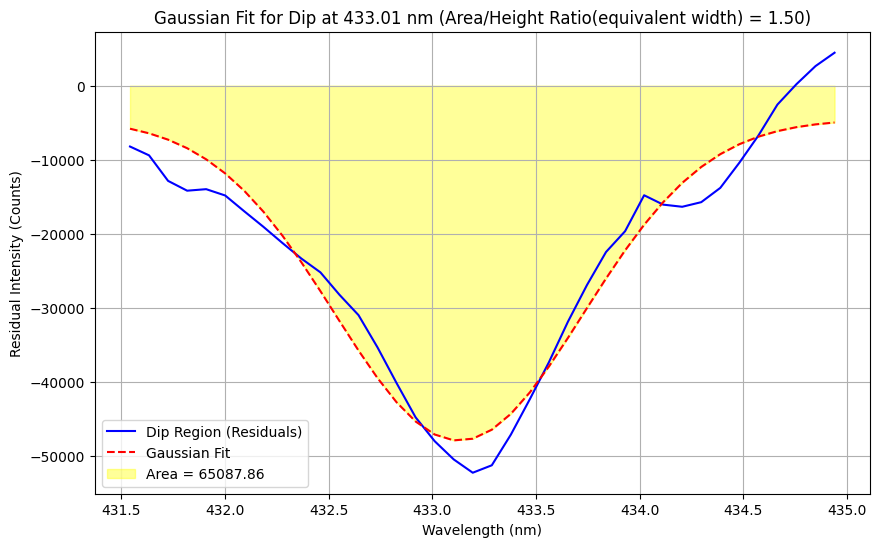

In [123]:
def identify_and_fit_gaussian_to_dips_F_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450)):
    """
    Identify the significant dips in the spectrum of the F star,
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    """
    # Process only the third star's corrected spectra image (F star)
    corrected_image = corrected_spectra_images[2]
    
    # Extract object and sky flux for the F star
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=2)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Manually select the four significant dips for the F star
    significant_dip_wavelengths = [392.25, 395.7, 409.2, 417, 433.01]  # Approximate positions of the dips in nm
    significant_dip_fluxes = []

    for wavelength in significant_dip_wavelengths:
        closest_index = np.argmin(np.abs(dip_wavelengths - wavelength))
        significant_dip_fluxes.append(dip_fluxes[closest_index])

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 3 (F Star, Alpha Persei)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, [converted_object_flux[dip_indices[np.argmin(np.abs(dip_wavelengths - wavelength))]] for wavelength in significant_dip_wavelengths], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 3 (F Star)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point
        if dip_wavelength == 433.01:
            start, end = 431.5, 435  # Specific range for the dip at 432 nm
        elif dip_wavelength in [392.25, 395.7]:
            start, end = dip_wavelength - 1.5, dip_wavelength + 1.5  # Smaller range for dips between 390 and 400 nm
        else:
            start, end = dip_wavelength - 1.5, dip_wavelength + 1.5
        
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='yellow', alpha=0.4, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm (Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to identify and fit Gaussians to the dips in the F star spectrum
identify_and_fit_gaussian_to_dips_F_star(corrected_spectra_images, coefficients)


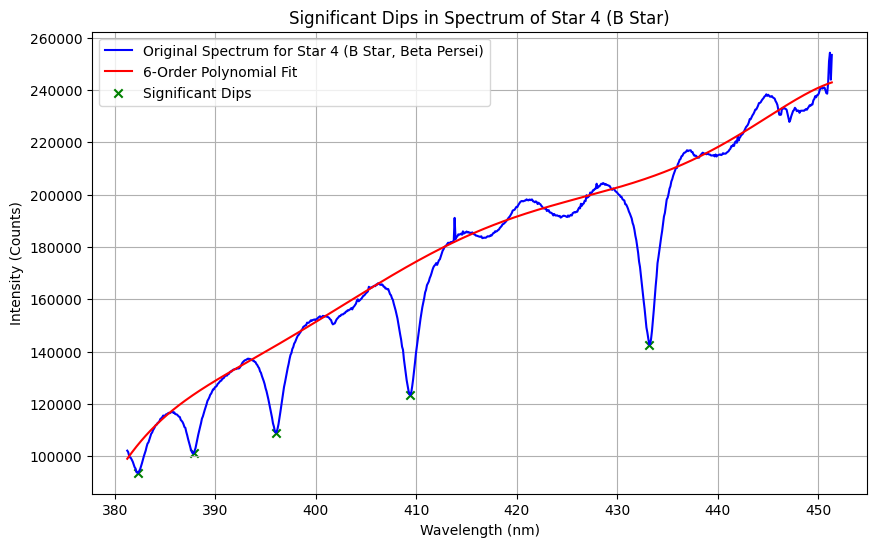

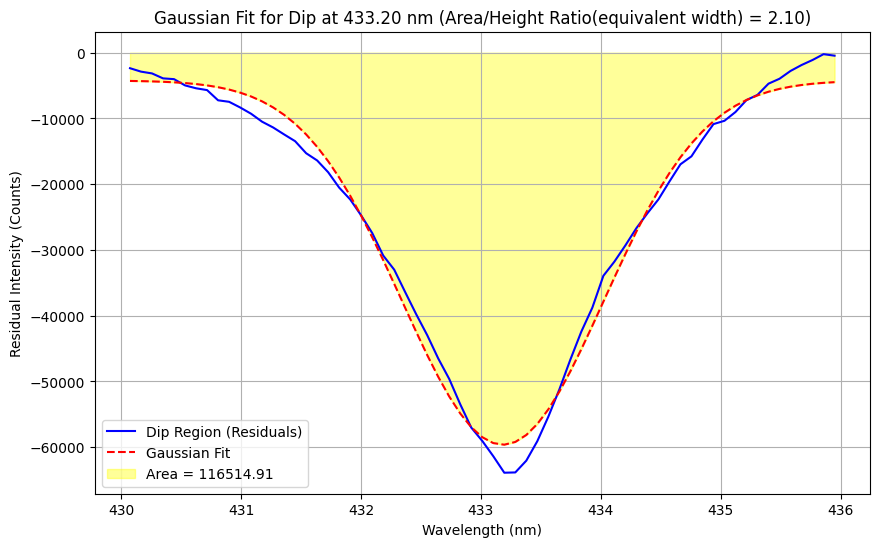

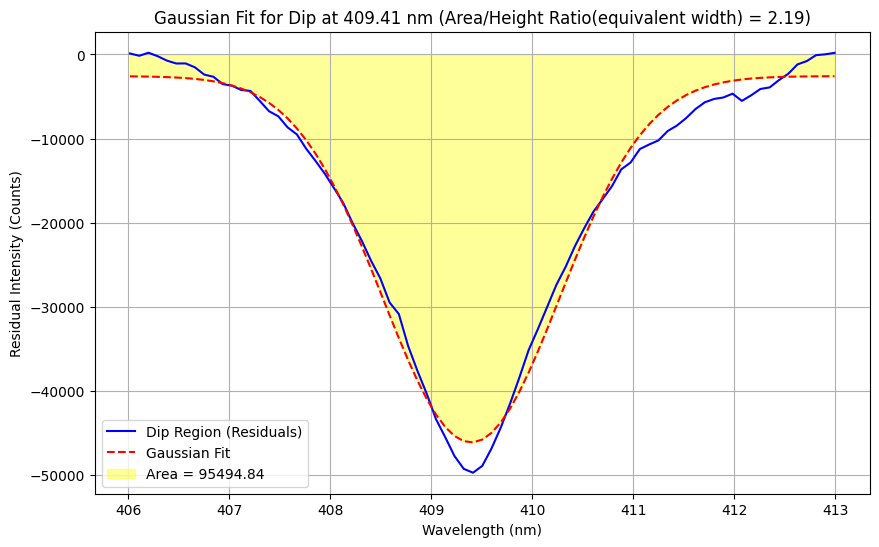

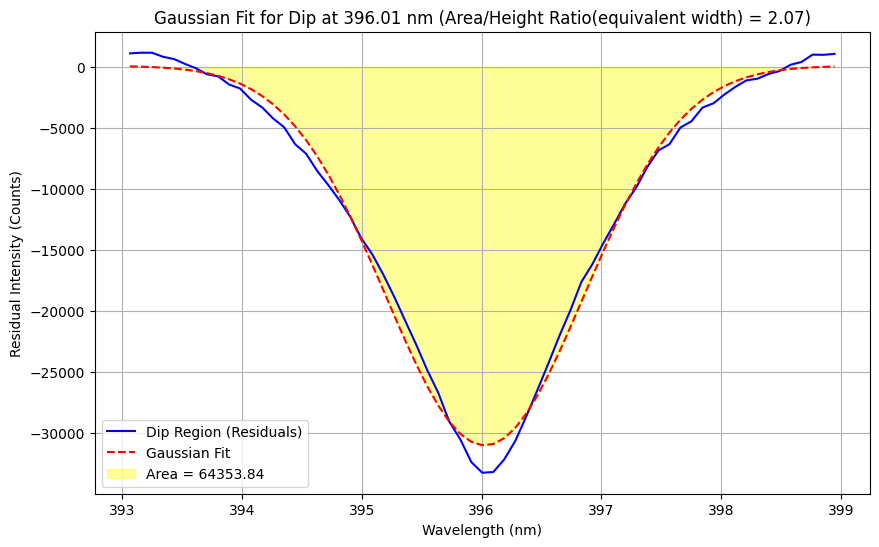

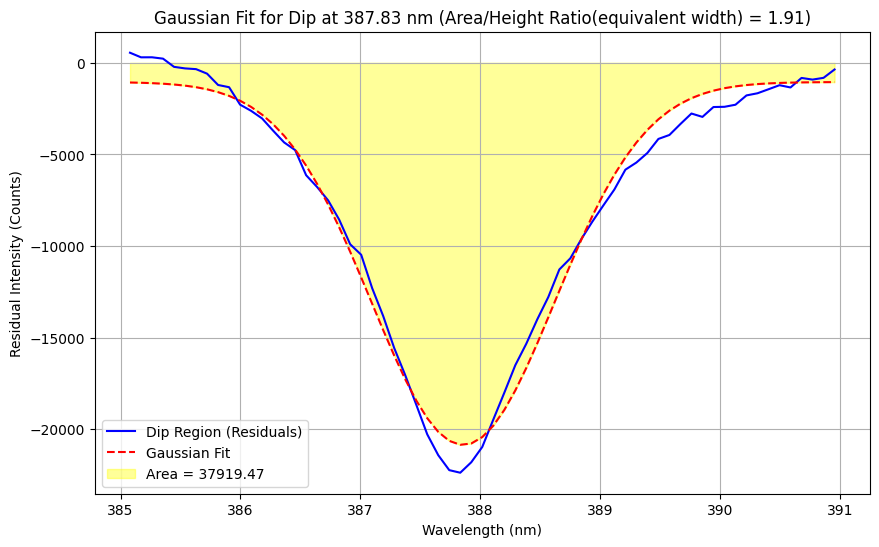

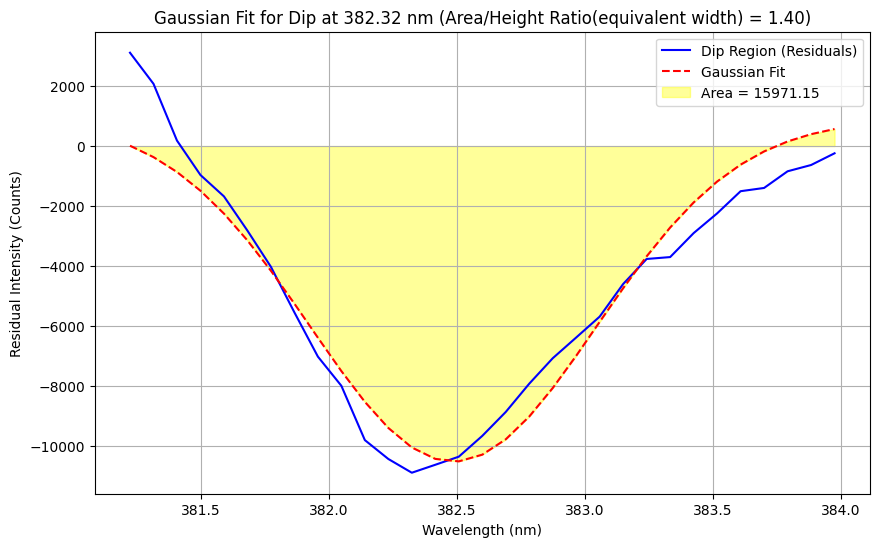

In [124]:
def identify_and_fit_gaussian_to_dips_B_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450), num_dips=5):
    """
    Identify the most significant dips in the spectrum of the B star,
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    :param num_dips: Number of most significant dips to identify (default is 5).
    :type num_dips: int
    """
    # Process only the third star's corrected spectra image (B star)
    corrected_image = corrected_spectra_images[3]
    
    # Extract object and sky flux for the B star
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=3)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Select the most significant dips (lowest values)
    sorted_indices = np.argsort(dip_fluxes)[:num_dips]
    significant_dip_wavelengths = dip_wavelengths[sorted_indices]
    significant_dip_fluxes = dip_fluxes[sorted_indices]

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 4 (B Star, Beta Persei)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, converted_object_flux[dip_indices][sorted_indices], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 4 (B Star)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point
        if 381 <= dip_wavelength <= 383:
            start, end = 381, 384  # Specific range for the dip at around 382 nm
        elif 387 <= dip_wavelength <= 388:
            start, end = 385, 391
        elif 409 <= dip_wavelength <= 410:
            start, end = 406, 413
        elif 433 <= dip_wavelength <= 434:
            start, end = 430, 436
        else:
            start, end = dip_wavelength - 3, dip_wavelength + 3
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='yellow', alpha=0.4, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm (Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to identify and fit Gaussians to the dips in the B star spectrum
identify_and_fit_gaussian_to_dips_B_star(corrected_spectra_images, coefficients)



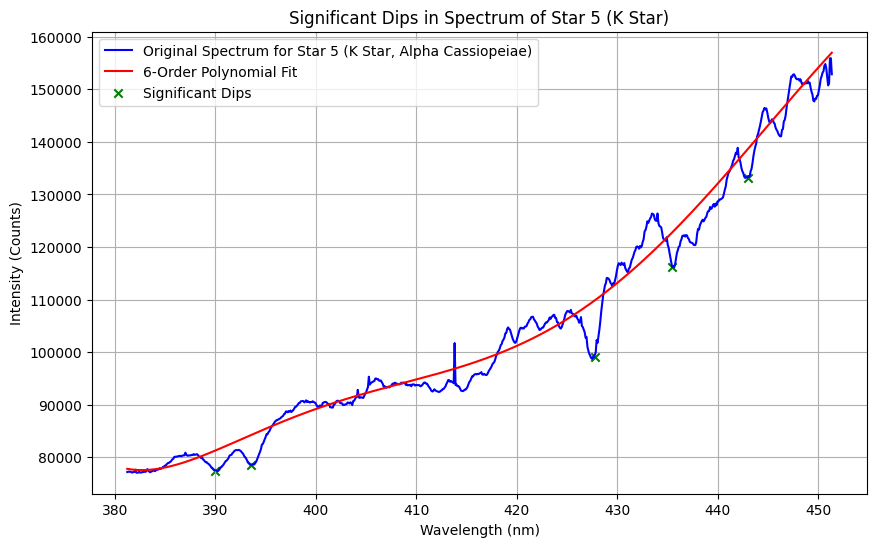

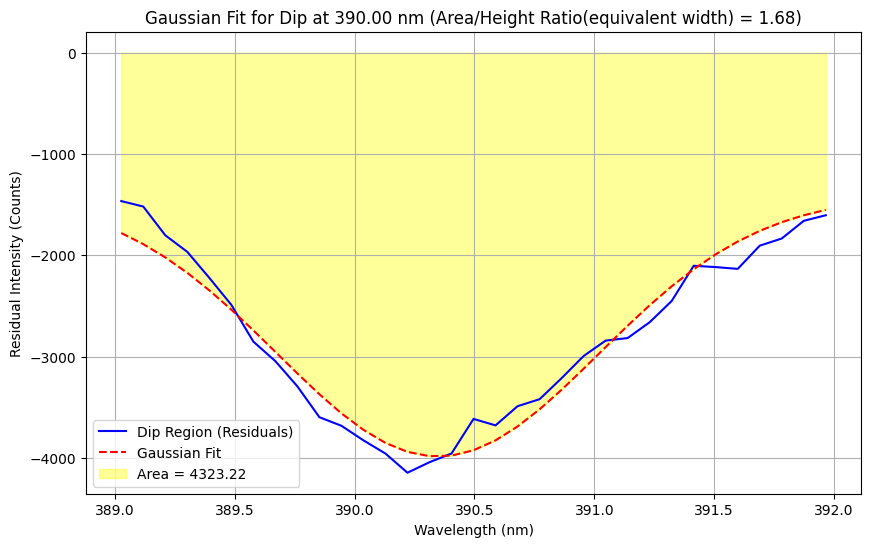

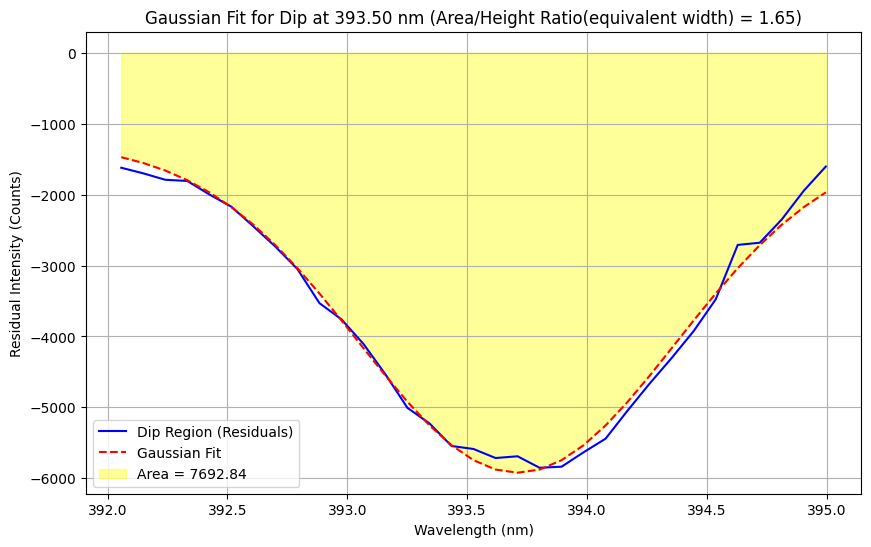

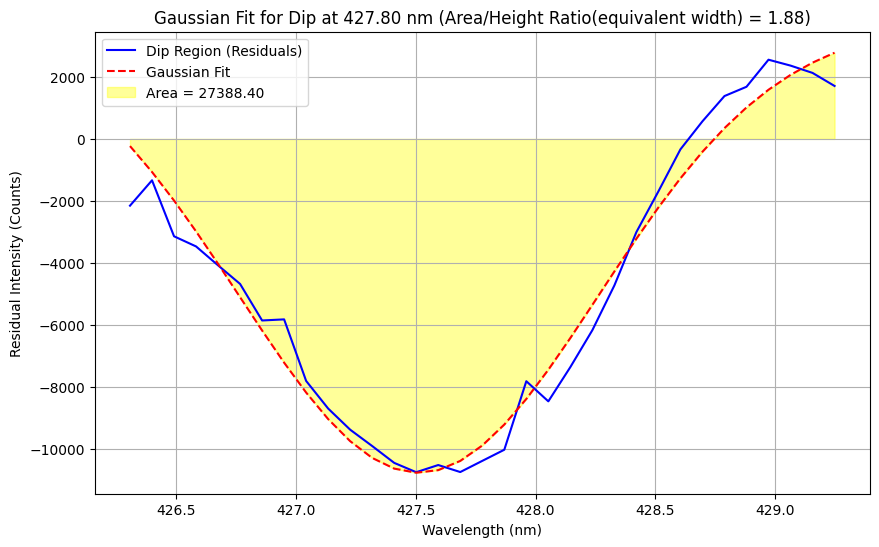

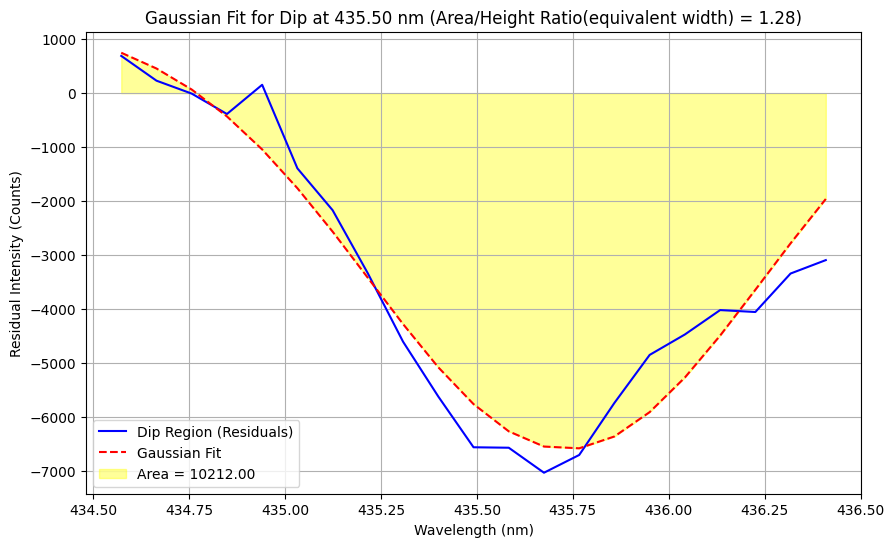

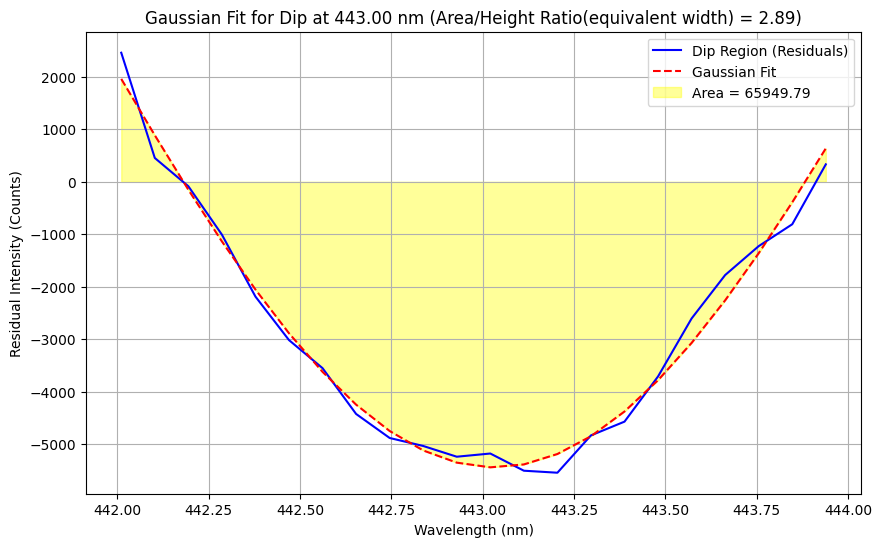

In [125]:
def identify_and_fit_gaussian_to_dips_K_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450)):
    """
    Identify the significant dips in the spectrum of the K star,
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    """
    # Process only the fifth star's corrected spectra image (K star)
    corrected_image = corrected_spectra_images[4]
    
    # Extract object and sky flux for the K star
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=4)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Manually select the significant dips for the K star
    significant_dip_wavelengths = [390, 393.5, 427.8, 435.5, 443]  # Approximate positions of the dips in nm
    significant_dip_fluxes = []

    for wavelength in significant_dip_wavelengths:
        closest_index = np.argmin(np.abs(dip_wavelengths - wavelength))
        significant_dip_fluxes.append(dip_fluxes[closest_index])

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 5 (K Star, Alpha Cassiopeiae)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, [converted_object_flux[dip_indices[np.argmin(np.abs(dip_wavelengths - wavelength))]] for wavelength in significant_dip_wavelengths], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 5 (K Star)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point
        if dip_wavelength == 390:
            start, end = 389, 392  # Specific range for the dip near 390 nm
        elif dip_wavelength == 393.5:
            start, end = 392, 395  # Specific range for the dip near 393.5 nm
        elif dip_wavelength == 435.5:
            start, end = 434.5, 436.5  # Specific range for the dip at 435.5 nm
        elif dip_wavelength == 443:
            start, end = 442, 444  # Specific range for the dip at 443 nm
        else:
            start, end = dip_wavelength - 1.5, dip_wavelength + 1.5

        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='yellow', alpha=0.4, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm (Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to identify and fit Gaussians to the dips in the K star spectrum
identify_and_fit_gaussian_to_dips_K_star(corrected_spectra_images, coefficients)


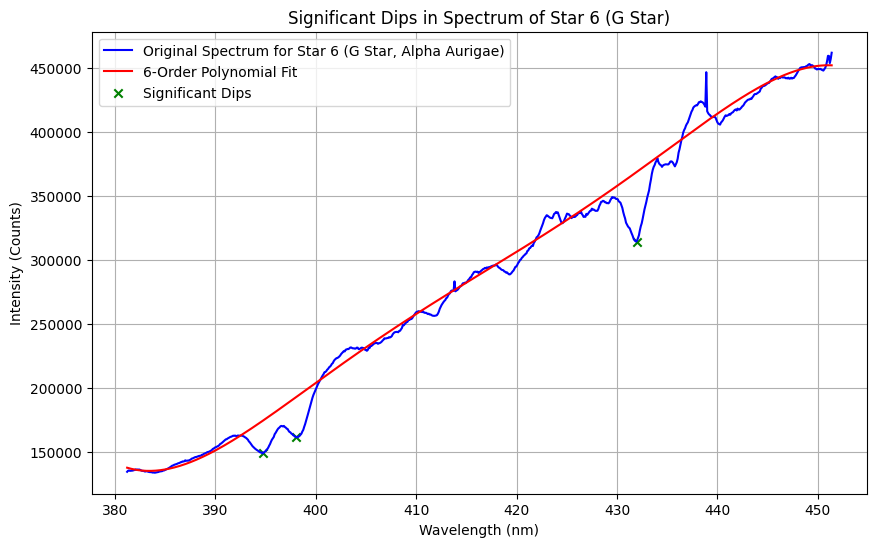

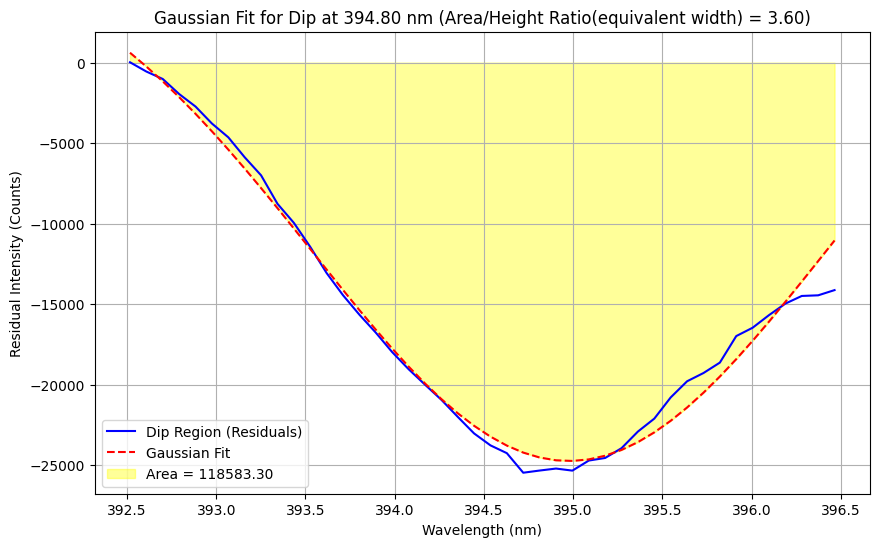

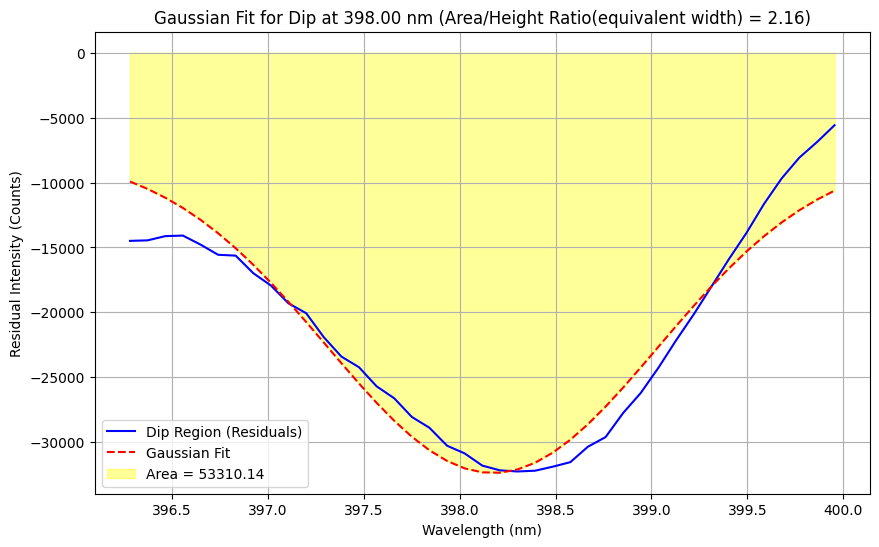

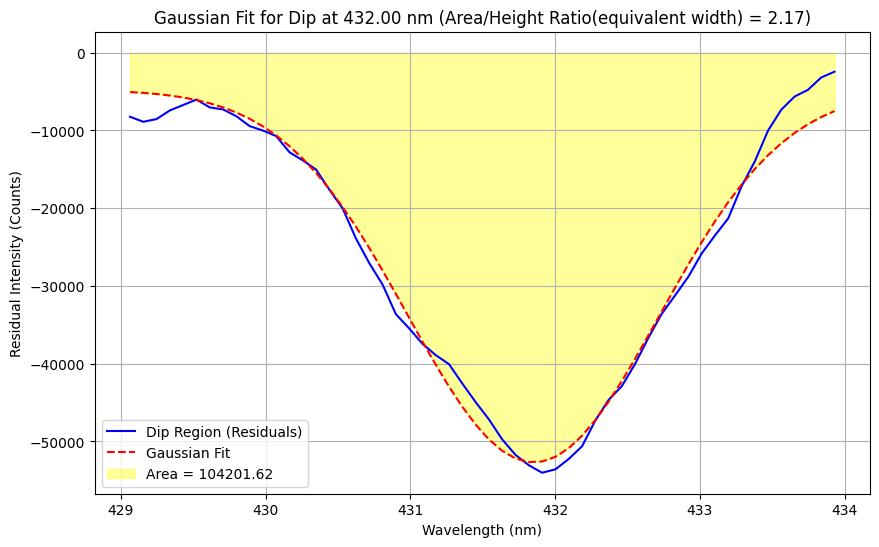

In [126]:
def identify_and_fit_gaussian_to_dips_G_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450)):
    """
    Identify the significant dips in the spectrum of the G star,
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    """
    # Process only the sixth star's corrected spectra image (G star)
    corrected_image = corrected_spectra_images[5]
    
    # Extract object and sky flux for the G star
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=5)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Manually select the three significant dips for the G star
    significant_dip_wavelengths = [394.8, 398, 432]  # Approximate positions of the dips in nm
    significant_dip_fluxes = []

    for wavelength in significant_dip_wavelengths:
        closest_index = np.argmin(np.abs(dip_wavelengths - wavelength))
        significant_dip_fluxes.append(dip_fluxes[closest_index])

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 6 (G Star, Alpha Aurigae)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, [converted_object_flux[dip_indices[np.argmin(np.abs(dip_wavelengths - wavelength))]] for wavelength in significant_dip_wavelengths], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 6 (G Star)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point
        if dip_wavelength == 394.8:
            start, end = 392.5, 396.5  # Specific range for the dips between 390 and 400 nm
        elif dip_wavelength == 398:
            start, end = 396.2, 400
        elif dip_wavelength == 432:
            start, end = 429, 434  # Specific range for the dip at 432 nm
        else:
            start, end = dip_wavelength - 5, dip_wavelength + 5
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='yellow', alpha=0.4, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm (Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to identify and fit Gaussians to the dips in the G star spectrum
identify_and_fit_gaussian_to_dips_G_star(corrected_spectra_images, coefficients)



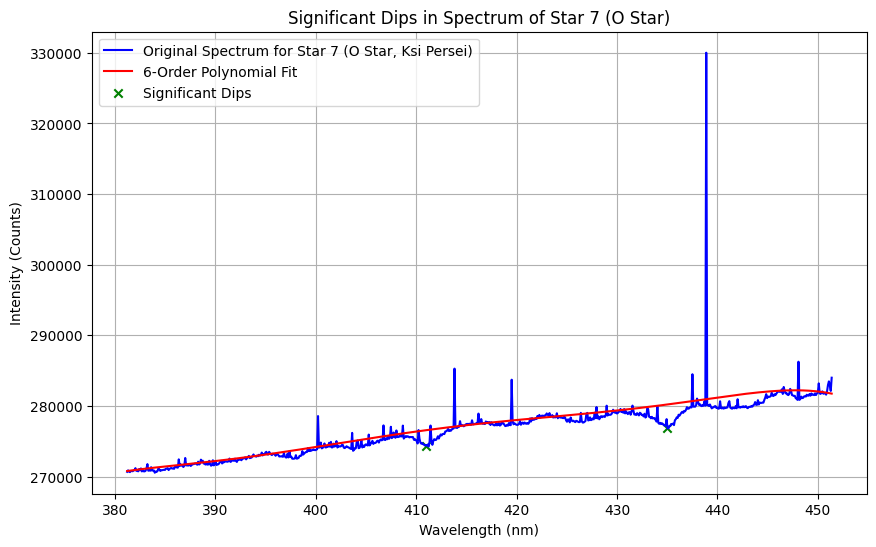

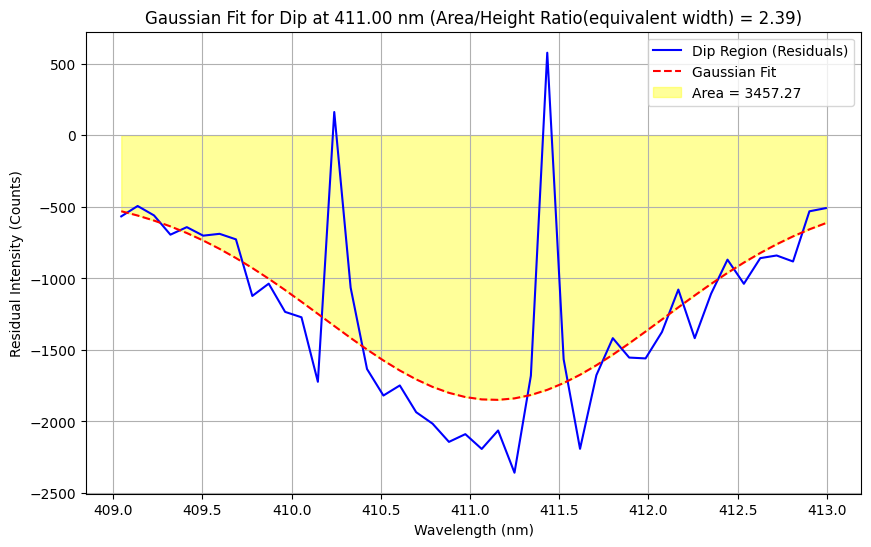

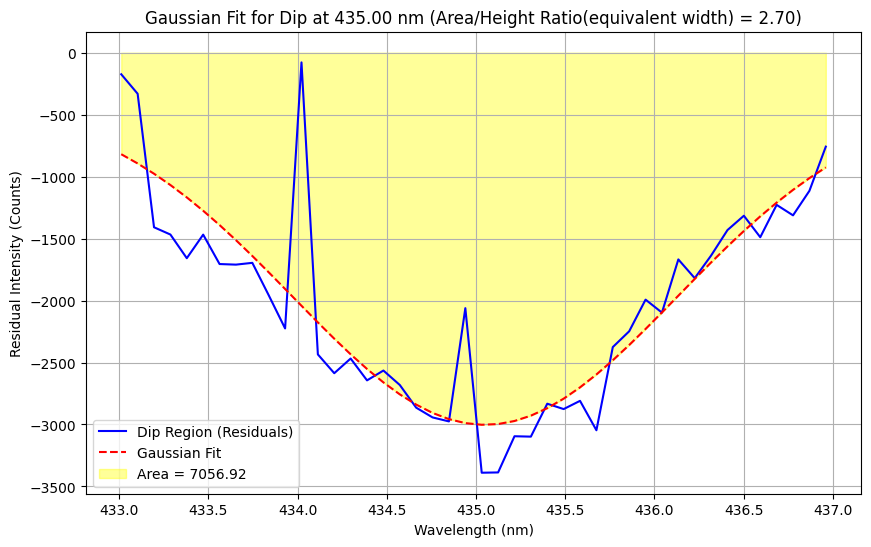

In [127]:
def identify_and_fit_gaussian_to_dips_O_star(corrected_spectra_images, coefficients, degree=6, wavelength_range=(380, 450)):
    """
    Identify the significant dips in the spectrum of the O star,
    subtract the fitted polynomial at each dip, and fit a Gaussian to each dip.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param degree: Degree of the polynomial to fit the peaks of the spectrum (default is 6).
    :type degree: int
    :param wavelength_range: The range of wavelengths to consider for identifying dips (default is 380-450 nm).
    :type wavelength_range: tuple
    """
    # Process only the seventh star's corrected spectra image (O star)
    corrected_image = corrected_spectra_images[6]
    
    # Extract object and sky flux for the O star
    object_flux, sky_flux = extract_target_sky_flux(corrected_image, star_index=6)
    # Convert pixel positions to wavelengths (nm) using the provided coefficients
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(degree, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Calculate the residuals (difference between the spectrum and the fit)
    residuals = converted_object_flux - fit_values

    # Find dips (negative peaks) in the residuals
    dip_indices, _ = find_peaks(-residuals)
    dip_wavelengths = wavelengths[dip_indices]
    dip_fluxes = residuals[dip_indices]

    # Filter dips within the specified wavelength range
    mask = (dip_wavelengths >= wavelength_range[0]) & (dip_wavelengths <= wavelength_range[1])
    dip_wavelengths = dip_wavelengths[mask]
    dip_fluxes = dip_fluxes[mask]

    # Manually select the two significant dips for the O star
    significant_dip_wavelengths = [411, 435]  # Approximate positions of the dips in nm
    significant_dip_fluxes = []

    for wavelength in significant_dip_wavelengths:
        closest_index = np.argmin(np.abs(dip_wavelengths - wavelength))
        significant_dip_fluxes.append(dip_fluxes[closest_index])

    # Plot the original spectrum, polynomial fit, and identified dips
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 7 (O Star, Ksi Persei)', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit', color='red')
    plt.scatter(significant_dip_wavelengths, [converted_object_flux[dip_indices[np.argmin(np.abs(dip_wavelengths - wavelength))]] for wavelength in significant_dip_wavelengths], color='green', marker='x', label='Significant Dips')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Significant Dips in Spectrum of Star 7 (O Star)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Fit a Gaussian to each significant dip
    for dip_wavelength, dip_flux in zip(significant_dip_wavelengths, significant_dip_fluxes):
        # Define a range around the dip point
        if dip_wavelength == 411:
            start, end = 409, 413  # Specific range for the dip at 411 nm
        elif dip_wavelength == 435:
            start, end = 433, 437  # Specific range for the dip at 435 nm
        else:
            start, end = dip_wavelength - 5, dip_wavelength + 5
        indices_in_range = np.where((wavelengths >= start) & (wavelengths <= end))[0]
        if len(indices_in_range) > 0:
            # Extract the relevant part of the spectrum for the dip region
            dip_wavelengths_range = wavelengths[indices_in_range]
            dip_flux_range = residuals[indices_in_range]

            # Initial guess for the Gaussian parameters
            amp_guess = np.min(dip_flux_range)  # Negative peak value
            mu_guess = dip_wavelength
            stddev_guess = 1.0

            # Define the model: Gaussian + Constant
            g_init = models.Gaussian1D(amplitude=amp_guess, mean=mu_guess, stddev=stddev_guess) + models.Const1D()

            # Fit the model to the data
            fitter = fitting.LevMarLSQFitter()
            g_fit = fitter(g_init, dip_wavelengths_range, dip_flux_range)

            # Get the Gaussian component
            gaussian_component = g_fit[0]

            # Calculate the area under the Gaussian curve
            area = np.sqrt(2 * np.pi) * abs(gaussian_component.amplitude.value) * abs(gaussian_component.stddev.value)

            # Calculate the area divided by the height of the Gaussian peak
            height = abs(gaussian_component.amplitude.value)
            area_height_ratio = area / height

            # Plot the dip region with the Gaussian fit and highlight the area
            plt.figure(figsize=(10, 6))
            plt.plot(dip_wavelengths_range, dip_flux_range, 'b-', label='Dip Region (Residuals)')
            plt.plot(dip_wavelengths_range, g_fit(dip_wavelengths_range), 'r--', label='Gaussian Fit')
            plt.fill_between(dip_wavelengths_range, 0, g_fit(dip_wavelengths_range), color='yellow', alpha=0.4, label=f'Area = {area:.2f}')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Residual Intensity (Counts)')
            plt.title(f'Gaussian Fit for Dip at {dip_wavelength:.2f} nm (Area/Height Ratio(equivalent width) = {area_height_ratio:.2f})')
            plt.legend()
            plt.grid(True)
            plt.show()

# Call the function to identify and fit Gaussians to the dips in the O star spectrum
identify_and_fit_gaussian_to_dips_O_star(corrected_spectra_images, coefficients)


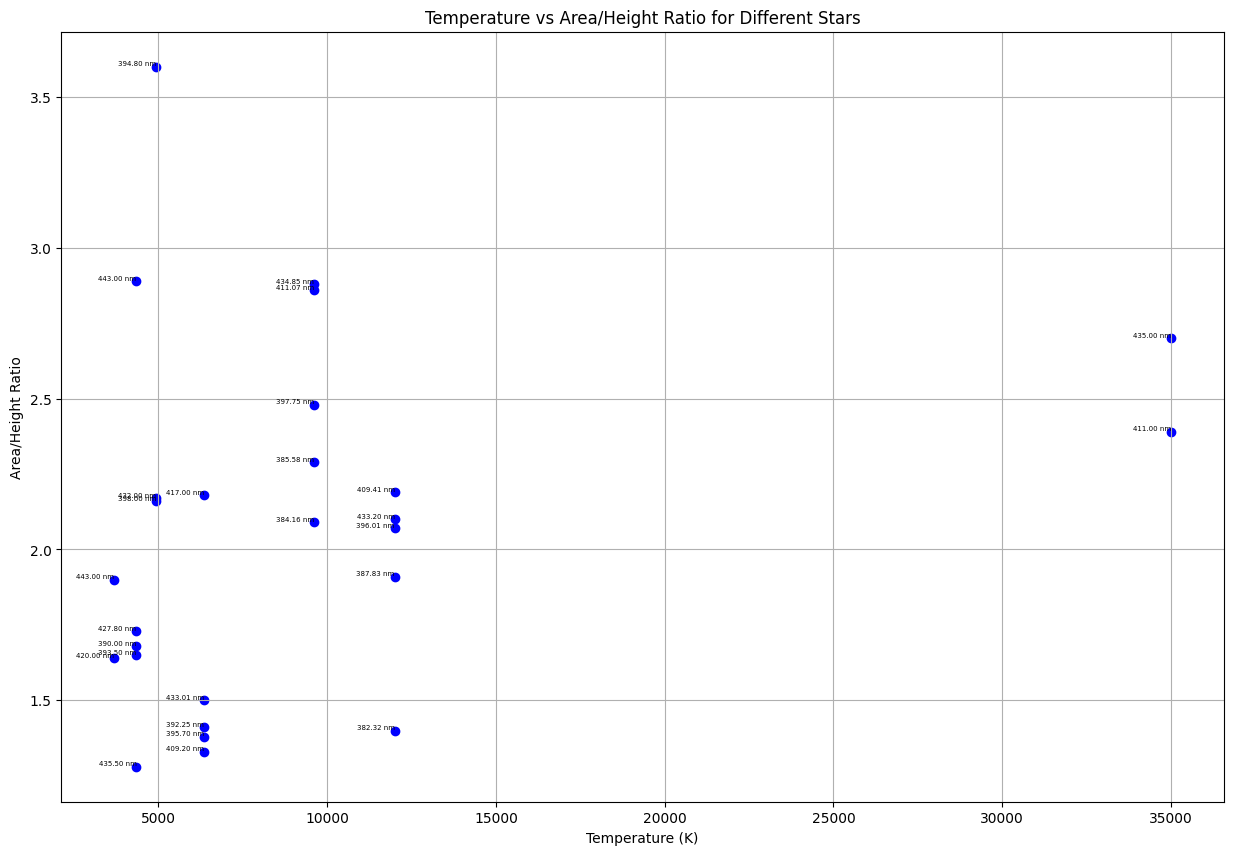

In [128]:
# Star data
star_data = {
    'A': {'temperature': 9602, 'area_height_ratios': [2.88, 2.86, 2.48, 2.29, 2.09], 'wavelengths': [434.85, 411.07, 397.75, 385.58, 384.16]},
    'M': {'temperature': 3689, 'area_height_ratios': [1.64, 1.9], 'wavelengths': [420, 443]},
    'F': {'temperature': 6350, 'area_height_ratios': [1.41, 1.38, 1.33, 2.18, 1.5], 'wavelengths': [392.25, 395.7, 409.2, 417, 433.01]},
    'B': {'temperature': 12000, 'area_height_ratios': [2.1, 2.19, 2.07, 1.91, 1.4], 'wavelengths': [433.2, 409.41, 396.01, 387.83, 382.32]},
    'K': {'temperature': 4350, 'area_height_ratios': [1.68, 1.65, 1.73, 1.28, 2.89], 'wavelengths': [390, 393.5, 427.8, 435.5, 443]},
    'G': {'temperature': 4940, 'area_height_ratios': [3.6, 2.16, 2.17], 'wavelengths': [394.8, 398, 432]},
    'O': {'temperature': 35000, 'area_height_ratios': [2.39, 2.7], 'wavelengths': [411, 435]},
}

# Prepare data for plotting
temperatures = []
area_height_ratios = []
wavelength_labels = []

for star, data in star_data.items():
    temp = data['temperature']
    for ratio, wavelength in zip(data['area_height_ratios'], data['wavelengths']):
        temperatures.append(temp)
        area_height_ratios.append(ratio)
        wavelength_labels.append(wavelength)

# Plot the data
plt.figure(figsize=(15,10))
plt.scatter(temperatures, area_height_ratios, color='blue', marker='o')

# Label each point with the corresponding wavelength
for temp, ratio, wavelength in zip(temperatures, area_height_ratios, wavelength_labels):
    plt.text(temp, ratio, f'{wavelength:.2f} nm', fontsize=5, ha='right', va='bottom')

plt.xlabel('Temperature (K)')
plt.ylabel('Area/Height Ratio')
plt.title('Temperature vs Area/Height Ratio for Different Stars')
plt.grid(True)
plt.show()


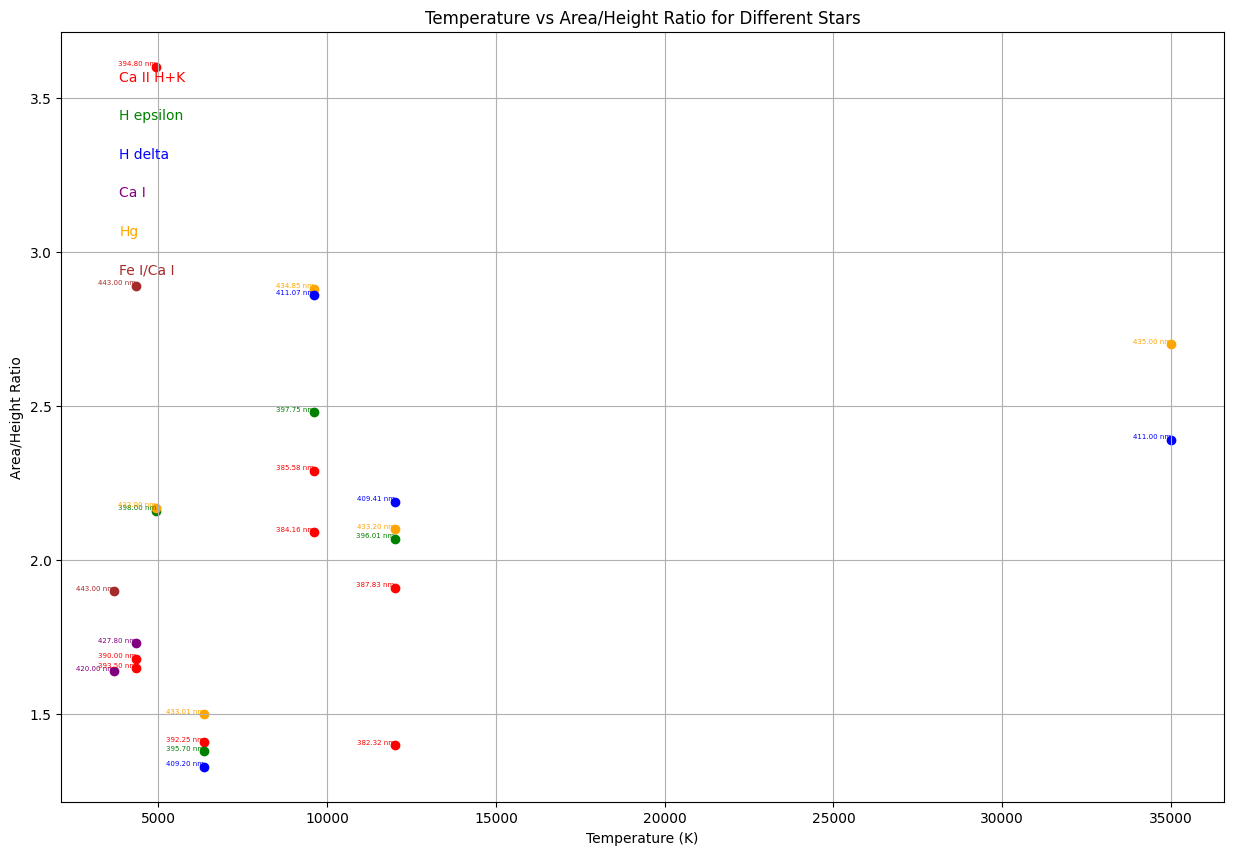

In [129]:
# Star data
star_data = {
    'A': {'temperature': 9602, 'area_height_ratios': [2.88, 2.86, 2.48, 2.29, 2.09], 'wavelengths': [434.85, 411.07, 397.75, 385.58, 384.16]},
    'M': {'temperature': 3689, 'area_height_ratios': [1.64, 1.9], 'wavelengths': [420, 443]},
    'F': {'temperature': 6350, 'area_height_ratios': [1.41, 1.38, 1.33, 2.18, 1.5], 'wavelengths': [392.25, 395.7, 409.2, 417, 433.01]},
    'B': {'temperature': 12000, 'area_height_ratios': [2.1, 2.19, 2.07, 1.91, 1.4], 'wavelengths': [433.2, 409.41, 396.01, 387.83, 382.32]},
    'K': {'temperature': 4350, 'area_height_ratios': [1.68, 1.65, 1.73, 1.28, 2.89], 'wavelengths': [390, 393.5, 427.8, 435.5, 443]},
    'G': {'temperature': 4940, 'area_height_ratios': [3.6, 2.16, 2.17], 'wavelengths': [394.8, 398, 432]},
    'O': {'temperature': 35000, 'area_height_ratios': [2.39, 2.7], 'wavelengths': [411, 435]},
}

# Prepare data for plotting
colors = {
    'Ca II H+K': 'red',
    'H epsilon': 'green',
    'H delta': 'blue',
    'Ca I': 'purple',
    'Hg': 'orange',
    'Fe I/Ca I': 'brown'
}

wavelength_ranges = {
    'Ca II H+K': (382, 394.8),
    'H epsilon': (395, 398),
    'H delta': (409, 412),
    'Ca I': (420, 430),
    'Hg': (431, 435),
    'Fe I/Ca I': (440, 445)
}

# Plot the data
plt.figure(figsize=(15, 10))

# Loop over each star and plot the points based on the wavelength ranges
for star, data in star_data.items():
    temp = data['temperature']
    for ratio, wavelength in zip(data['area_height_ratios'], data['wavelengths']):
        # Determine the color based on the wavelength range
        for label, (low, high) in wavelength_ranges.items():
            if low <= wavelength <= high:
                plt.scatter(temp, ratio, color=colors[label], marker='o')
                plt.text(temp, ratio, f'{wavelength:.2f} nm', fontsize=5, ha='right', va='bottom', color=colors[label])
                break

# Add labels for each group
plt.text(0.05, 0.95, 'Ca II H+K', color='red', fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.90, 'H epsilon', color='green', fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, 'H delta', color='blue', fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.80, 'Ca I', color='purple', fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.75, 'Hg', color='orange', fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.05, 0.70, 'Fe I/Ca I', color='brown', fontsize=10, ha='left', va='top', transform=plt.gca().transAxes)

# Final plot formatting
plt.xlabel('Temperature (K)')
plt.ylabel('Area/Height Ratio')
plt.title('Temperature vs Area/Height Ratio for Different Stars')
plt.grid(True)
plt.show()
